# VarnaAir - Open Programme

## Introduction ℹ️
VarnaAir is a machine learning project focused on predicting the Air Quality Index (AQI) for Varna, Bulgaria. The project applies regression models to forecast AQI levels.

I chose Varna for this project because it is my hometown and I deeply care about the environmental impact of air pollution. As a coastal city, Varna faces significant pollution from its seaport, as well as from the airport and increasing traffic levels. More importantly, it is where my family and friends live, so their health and well-being are a strong personal motivation behind this project.


## Libraries 📚
First, let's begin by importing the libraries and checking their versions.

In [997]:
import numpy
import pandas
import sklearn
import seaborn
import requests
from pytz import timezone

import matplotlib.pyplot as plt

from sklearn.svm import SVR
# from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

print("Library versions:")
print("- pandas:", pandas.__version__)          # 2.2.3
print("- seaborn:", seaborn.__version__)        # 0.13.2
print("- sklearn:", sklearn.__version__)        # 1.6.1
print("- seaborn:", seaborn.__version__)        # 0.13.2

Library versions:
- pandas: 2.2.3
- seaborn: 0.13.2
- sklearn: 1.6.1
- seaborn: 0.13.2


## Data provisioning 📦

Next, we will use a free to use API key provided by Air Pollution API [https://openweathermap.org/api/air-pollution].

Besides basic Air Quality Index, the API returns data about polluting gases, such as Carbon monoxide (CO), Nitrogen monoxide (NO), Nitrogen dioxide (NO2), Ozone (O3), Sulphur dioxide (SO2), Ammonia (NH3) and particulates (PM2.5 and PM10).

The data spans from January 1, 2023 (00:00:00 UTC) to June 25, 2025 (00:00:00 UTC) as of today.

In [998]:
url = "http://api.openweathermap.org/data/2.5/air_pollution/history?lat=43.224389&lon=27.915733&start=1672531200&end=1750819200&appid=6964febcb17ba6ff6b81e9dc9f05d7cc"

response = requests.get(url)

data = response.json()
data_list = data.get('list', [])

df = pandas.json_normalize(data_list)
df['dt'] = pandas.to_datetime(df['dt'], unit='s')

df

dt  main.aqi  components.co  components.no  \
0     2023-01-01 00:00:00       2.0         300.41           0.05   
1     2023-01-01 01:00:00       2.0         283.72           0.01   
2     2023-01-01 02:00:00       2.0         280.38           0.01   
3     2023-01-01 03:00:00       2.0         283.72           0.01   
4     2023-01-01 04:00:00       2.0         283.72           0.01   
...                   ...       ...            ...            ...   
21262 2025-06-24 22:00:00       1.0         124.73           0.00   
21263 2025-06-24 23:00:00       1.0         125.38           0.00   
21264 2025-06-25 00:00:00       1.0         126.58           0.00   
21265 2025-06-25 01:00:00       1.0         127.10           0.00   
21266 2025-06-25 02:00:00       1.0         126.65           0.00   

       components.no2  components.o3  components.so2  components.pm2_5  \
0               14.74          18.78            2.26             17.98   
1               11.48          28.61            2.18             15.54   
2               10.11          30.76            2.12             14.57   
3                9.51          31.47            2.15             14.03   
4                9.08          34.33            2.26             13.40   
...               ...            ...             ...               ...   
21262            3.43          57.67            1.28              8.19   
21263            3.03          56.35            1.31              8.21   
21264            2.67          55.99            1.37              8.21   
21265            2.33          57.80            1.47              8.11   
21266            2.10          56.72            1.34              8.04   

       components.pm10  components.nh3  
0                20.54            0.13  
1                17.46            0.09  
2                16.24            0.09  
3                15.58            0.10  
4                14.91            0.12  
...                ...             ...  
21262            10.18            2.77  
21263            10.19            2.77  
21264            10.21            2.75  
21265            10.17            2.67  
21266            10.12            2.59  

[21267 rows x 10 columns]

To enhance readability and ensure clarity, we will rename the columns to make them more descriptive and consistent.

In [999]:
df.rename(columns={"dt": "datetime_UTC", 
                   "main.aqi": "AQI",
                   "components.co": "CO",
                   "components.no": "NO",
                   "components.no2": "NO2",
                   "components.o3": "O3",
                   "components.so2": "SO2",
                   "components.pm2_5": "PM2_5",
                   "components.pm10": "PM10",
                   "components.nh3": "NH3"}, inplace=True)
df

datetime_UTC  AQI      CO    NO    NO2     O3   SO2  PM2_5  \
0     2023-01-01 00:00:00  2.0  300.41  0.05  14.74  18.78  2.26  17.98   
1     2023-01-01 01:00:00  2.0  283.72  0.01  11.48  28.61  2.18  15.54   
2     2023-01-01 02:00:00  2.0  280.38  0.01  10.11  30.76  2.12  14.57   
3     2023-01-01 03:00:00  2.0  283.72  0.01   9.51  31.47  2.15  14.03   
4     2023-01-01 04:00:00  2.0  283.72  0.01   9.08  34.33  2.26  13.40   
...                   ...  ...     ...   ...    ...    ...   ...    ...   
21262 2025-06-24 22:00:00  1.0  124.73  0.00   3.43  57.67  1.28   8.19   
21263 2025-06-24 23:00:00  1.0  125.38  0.00   3.03  56.35  1.31   8.21   
21264 2025-06-25 00:00:00  1.0  126.58  0.00   2.67  55.99  1.37   8.21   
21265 2025-06-25 01:00:00  1.0  127.10  0.00   2.33  57.80  1.47   8.11   
21266 2025-06-25 02:00:00  1.0  126.65  0.00   2.10  56.72  1.34   8.04   

        PM10   NH3  
0      20.54  0.13  
1      17.46  0.09  
2      16.24  0.09  
3      15.58  0.10  
4      14.91  0.12  
...      ...   ...  
21262  10.18  2.77  
21263  10.19  2.77  
21264  10.21  2.75  
21265  10.17  2.67  
21266  10.12  2.59  

[21267 rows x 10 columns]

## Data Dictionary 📖

Below is a **data dictionary** with descriptions for the final key variables used in this dataset:

| No. | Column Name | Unit | Description|
|-----|---------------|----------|------|
| 1   | `datetime_UTC`| datetime | Local date and time of the air quality measurement in UTC. |
| 2   | `AQI` | 1(Good), 2(Fair), 3(Moderate), 4(Poor) and 5(Very Poor)  | Air Quality Index value calculated based on pollutant concentrations. |
| 3   | `CO`  | µg/m³                 | Concentration of carbon monoxide (CO).                                |
| 4   | `NO`  | µg/m³                 | Concentration of nitrogen monoxide (NO).                              |
| 5   | `NO2` | µg/m³                 | Concentration of nitrogen dioxide (NO₂).                              |
| 6   | `O3`  | µg/m³                 | Concentration of ozone (O₃).                                          |
| 7   | `SO2` | µg/m³                 | Concentration of sulfur dioxide (SO₂).                                |
| 8   | `PM2_5| µg/m³                 | Concentration of particulate matter with diameter ≤ 2.5 µm (PM₂.₅).   |
| 9   | `PM10`| µg/m³                 | Concentration of particulate matter with diameter ≤ 10 µm (PM₁₀).     |
| 10  | `NH3` | µg/m³                 | Concentration of ammonia (NH₃).                                       |

### Sample the data 📃
Let's sample the data to check how it looks so far.

In [1000]:
df.sample(10)

datetime_UTC  AQI      CO    NO    NO2     O3   SO2  PM2_5  \
3382  2023-05-24 22:00:00  2.0  320.43  0.01  15.08  27.18  3.67  14.01   
19160 2025-03-21 08:00:00  2.0  433.92  3.97  13.37  71.53  4.41  24.22   
20550 2025-05-26 06:00:00  1.0  107.14  0.13   1.22  36.24  0.08   1.56   
10756 2024-03-30 04:00:00  2.0  273.70  0.00  13.37  48.64  8.82  24.79   
19516 2025-04-12 04:00:00  2.0  148.76  0.00   0.78  82.24  0.22   1.25   
18074 2025-02-02 02:00:00  2.0  367.16  0.00   7.54  35.76  1.71  14.04   
18798 2025-03-04 06:00:00  3.0  594.14  2.18  23.99  25.75  3.46  26.49   
17752 2025-01-19 16:00:00  2.0  313.76  0.00   8.31  70.10  2.77   8.26   
13617 2024-07-30 09:00:00  2.0  185.25  0.12   0.92  82.25  0.72   1.17   
15737 2024-10-27 17:00:00  2.0  220.30  0.00   4.80  81.54  2.65   3.37   

        PM10   NH3  
3382   16.35  0.43  
19160  28.15  2.94  
20550   1.70  0.24  
10756  37.65  0.74  
19516   1.50  1.24  
18074  15.58  0.36  
18798  30.13  1.52  
17752   9.91  1.30  
13617   1.61  0.95  
15737   4.69  0.19

## Preprocessing 🛠️
Machine learning models learn patterns from the data they are given. If the data contains noise, inconsistencies or errors (e.g. typos, null values, duplicates), the model will likely learn misleading or irrelevant patterns - leading to poor performance and unreliable predictions. To prevent this, it is essential to check all rows that contain missing data. If such rows exist, a decision should be made about whether to remove them.
### Null values 0️⃣

In [1001]:
df.isnull().sum()

datetime_UTC    0
AQI             0
CO              0
NO              0
NO2             0
O3              0
SO2             0
PM2_5           0
PM10            0
NH3             0
dtype: int64

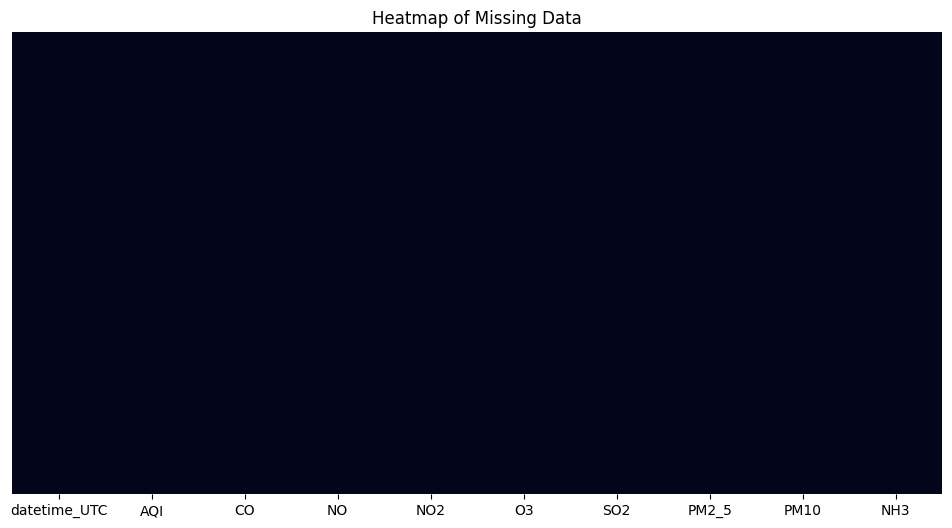

In [1002]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(df.isnull(), cbar=False, cmap='rocket', yticklabels=False)
plt.title('Heatmap of Missing Data')
plt.show()

The dataset contains no missing values, so no imputation or removal is required. 

In [1003]:
df.dtypes

datetime_UTC    datetime64[ns]
AQI                    float64
CO                     float64
NO                     float64
NO2                    float64
O3                     float64
SO2                    float64
PM2_5                  float64
PM10                   float64
NH3                    float64
dtype: object

There is also no wrong datatypes.

### Format dates 🗓️

In [1004]:
df['datetime_UTC'] = pandas.to_datetime(df['datetime_UTC'], utc=True)
df['datetime_local'] = df['datetime_UTC'].dt.tz_convert(timezone('Europe/Sofia'))
df = df.drop(columns=['datetime_UTC'])
df

AQI      CO    NO    NO2     O3   SO2  PM2_5   PM10   NH3  \
0      2.0  300.41  0.05  14.74  18.78  2.26  17.98  20.54  0.13   
1      2.0  283.72  0.01  11.48  28.61  2.18  15.54  17.46  0.09   
2      2.0  280.38  0.01  10.11  30.76  2.12  14.57  16.24  0.09   
3      2.0  283.72  0.01   9.51  31.47  2.15  14.03  15.58  0.10   
4      2.0  283.72  0.01   9.08  34.33  2.26  13.40  14.91  0.12   
...    ...     ...   ...    ...    ...   ...    ...    ...   ...   
21262  1.0  124.73  0.00   3.43  57.67  1.28   8.19  10.18  2.77   
21263  1.0  125.38  0.00   3.03  56.35  1.31   8.21  10.19  2.77   
21264  1.0  126.58  0.00   2.67  55.99  1.37   8.21  10.21  2.75   
21265  1.0  127.10  0.00   2.33  57.80  1.47   8.11  10.17  2.67   
21266  1.0  126.65  0.00   2.10  56.72  1.34   8.04  10.12  2.59   

                 datetime_local  
0     2023-01-01 02:00:00+02:00  
1     2023-01-01 03:00:00+02:00  
2     2023-01-01 04:00:00+02:00  
3     2023-01-01 05:00:00+02:00  
4     2023-01-01 06:00:00+02:00  
...                         ...  
21262 2025-06-25 01:00:00+03:00  
21263 2025-06-25 02:00:00+03:00  
21264 2025-06-25 03:00:00+03:00  
21265 2025-06-25 04:00:00+03:00  
21266 2025-06-25 05:00:00+03:00  

[21267 rows x 10 columns]

In [1005]:
df['datetime_local'] = df['datetime_local'].dt.tz_convert(timezone('Europe/Sofia'))

df['year'] = df['datetime_local'].dt.year
df['month'] = df['datetime_local'].dt.month
df['day'] = df['datetime_local'].dt.day
df['hour'] = df['datetime_local'].dt.hour
df['weekday'] = df['datetime_local'].dt.weekday + 1  # Monday as 1

df['datetime_local'] = df['datetime_local'].dt.strftime('%d-%m-%Y %H:%M')

df

AQI      CO    NO    NO2     O3   SO2  PM2_5   PM10   NH3  \
0      2.0  300.41  0.05  14.74  18.78  2.26  17.98  20.54  0.13   
1      2.0  283.72  0.01  11.48  28.61  2.18  15.54  17.46  0.09   
2      2.0  280.38  0.01  10.11  30.76  2.12  14.57  16.24  0.09   
3      2.0  283.72  0.01   9.51  31.47  2.15  14.03  15.58  0.10   
4      2.0  283.72  0.01   9.08  34.33  2.26  13.40  14.91  0.12   
...    ...     ...   ...    ...    ...   ...    ...    ...   ...   
21262  1.0  124.73  0.00   3.43  57.67  1.28   8.19  10.18  2.77   
21263  1.0  125.38  0.00   3.03  56.35  1.31   8.21  10.19  2.77   
21264  1.0  126.58  0.00   2.67  55.99  1.37   8.21  10.21  2.75   
21265  1.0  127.10  0.00   2.33  57.80  1.47   8.11  10.17  2.67   
21266  1.0  126.65  0.00   2.10  56.72  1.34   8.04  10.12  2.59   

         datetime_local  year  month  day  hour  weekday  
0      01-01-2023 02:00  2023      1    1     2        7  
1      01-01-2023 03:00  2023      1    1     3        7  
2      01-01-2023 04:00  2023      1    1     4        7  
3      01-01-2023 05:00  2023      1    1     5        7  
4      01-01-2023 06:00  2023      1    1     6        7  
...                 ...   ...    ...  ...   ...      ...  
21262  25-06-2025 01:00  2025      6   25     1        3  
21263  25-06-2025 02:00  2025      6   25     2        3  
21264  25-06-2025 03:00  2025      6   25     3        3  
21265  25-06-2025 04:00  2025      6   25     4        3  
21266  25-06-2025 05:00  2025      6   25     5        3  

[21267 rows x 15 columns]

## Data Analysis and Visualization 📊
Let's first check the AQI and its values.

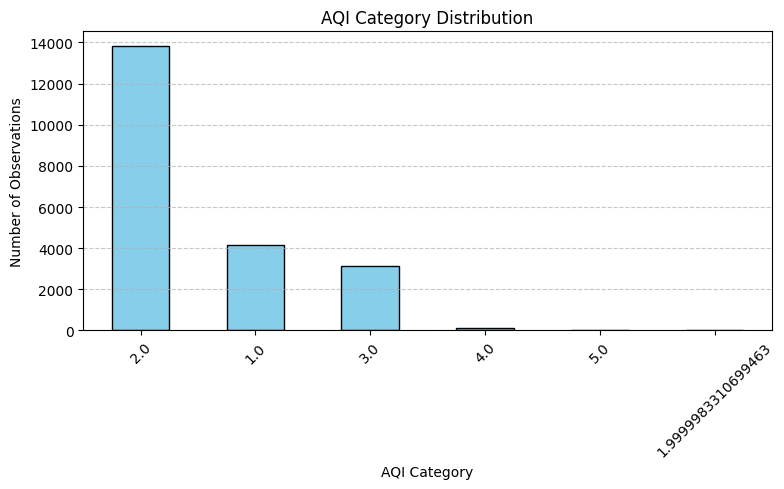

In [1006]:
category_counts = df['AQI'].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('AQI Category Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [1007]:
df['AQI'].value_counts()

AQI
2.000000    13846
1.000000     4170
3.000000     3122
4.000000      112
5.000000       16
1.999998        1
Name: count, dtype: int64

Since there should be only 1,2,3,4 and 5. We would have to investigate into why the last number is present.

In [1008]:
unique_rows = df[df['AQI'].duplicated(keep=False) == False]
print(unique_rows)

            AQI     CO    NO   NO2     O3   SO2  PM2_5  PM10   NH3  \
20719  1.999998  98.57  0.09  0.41  78.43  0.21    0.0   0.0  1.31   

         datetime_local  year  month  day  hour  weekday  
20719  02-06-2025 10:00  2025      6    2    10        1  


In [1009]:
df = df.dropna() 
df = df[df['AQI'].isin([1, 2, 3, 4, 5])]

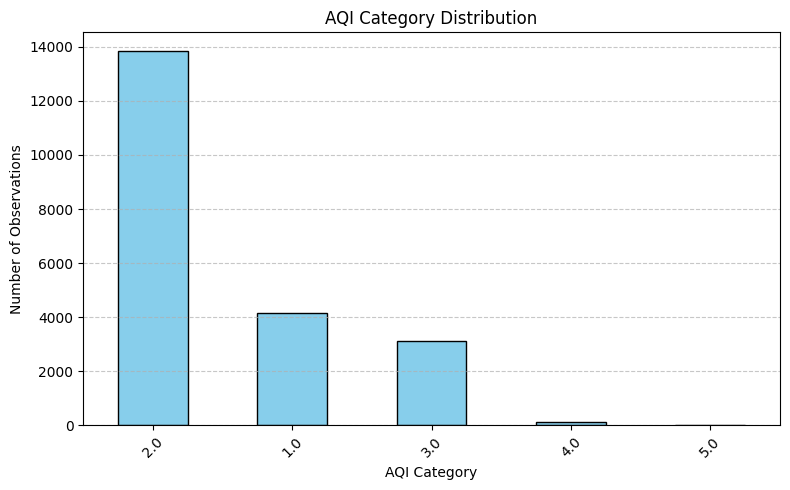

In [1010]:
category_counts = df['AQI'].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('AQI Category Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

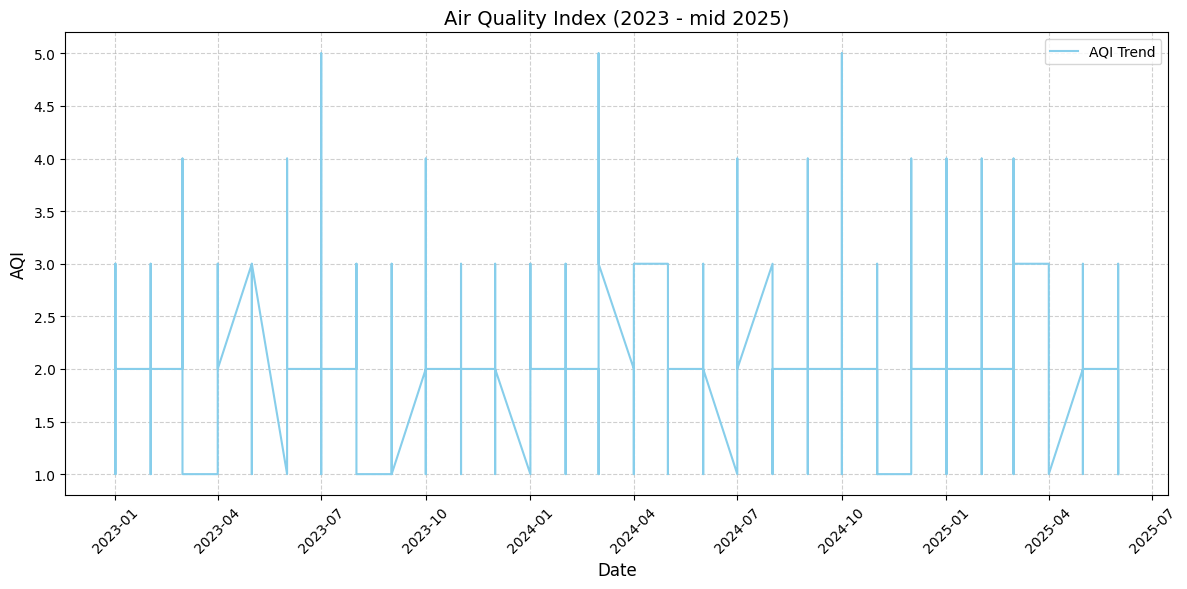

In [1011]:
df["datetime_local"] = pandas.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2),
    format='%Y-%m'
)

df.sort_values(by="datetime_local", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df["datetime_local"], df["AQI"], linestyle='-', color='skyblue', label='AQI Trend')
plt.title("Air Quality Index (2023 - mid 2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("AQI", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.legend()
plt.show()

Overall, There is no clear upward or downward trend in the values. They fluctuate sharply between 1 and 5 throughout the entire period. Peaks (value 5) and troughs (value 1) occur irregularly, with no seasonality or long-term pattern, suggesting that air quality is subject to short-term events rather than long-term changes.

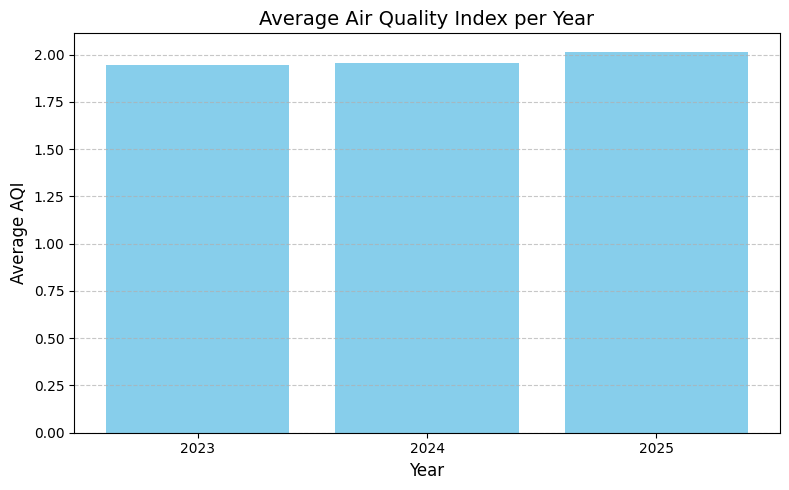

In [1012]:
yearly_avg = df.groupby("year")["AQI"].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(yearly_avg["year"], yearly_avg["AQI"], color='skyblue')
plt.title("Average Air Quality Index per Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average AQI", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_avg["year"], fontsize=10)
plt.tight_layout()
plt.show()

The data suggests a very mild upward trend in average AQI over the three years, indicating a small deterioration in air quality, but the change is minimal and the overall average remains nearly constant.

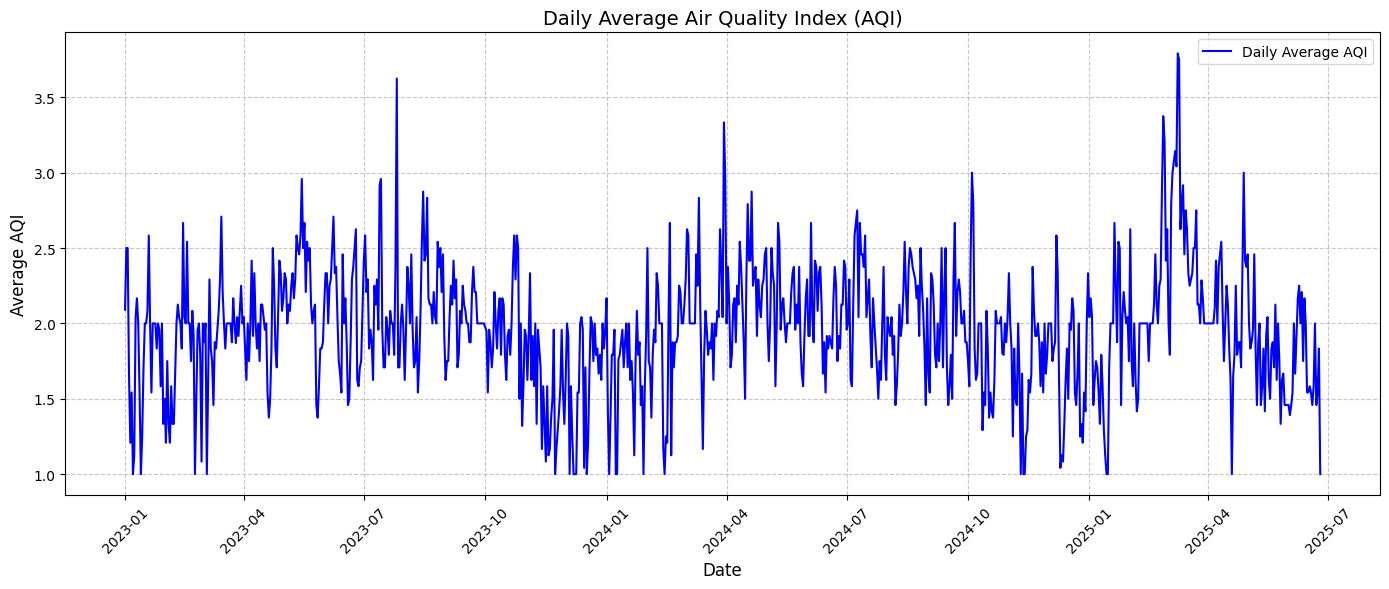

In [1013]:
df["datetime_local"] = pandas.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2) + "-" + df["day"].astype(str).str.zfill(2)
)

daily_avg = df.groupby("datetime_local")["AQI"].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(daily_avg["datetime_local"], daily_avg["AQI"], linestyle='-', color='b', label='Daily Average AQI')
plt.title("Daily Average Air Quality Index (AQI)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average AQI", fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.legend()
plt.show()

The primary trend observed is significant **daily fluctuation** without a clear, sustained long-term increase or decrease over the two-and-a-half-year period. There appears to be a **possible seasonal pattern**, with noticeable peaks in AQI during summer months (e.g., July-August in 2023 and 2024) and a very prominent high peak in early 2025 (around February-March). Conversely, periods like late 2023 and late 2024 (October-November) show relatively lower AQI values. In essence, the data suggests **volatility and potential seasonality** rather than a strong linear trend in air quality over time.

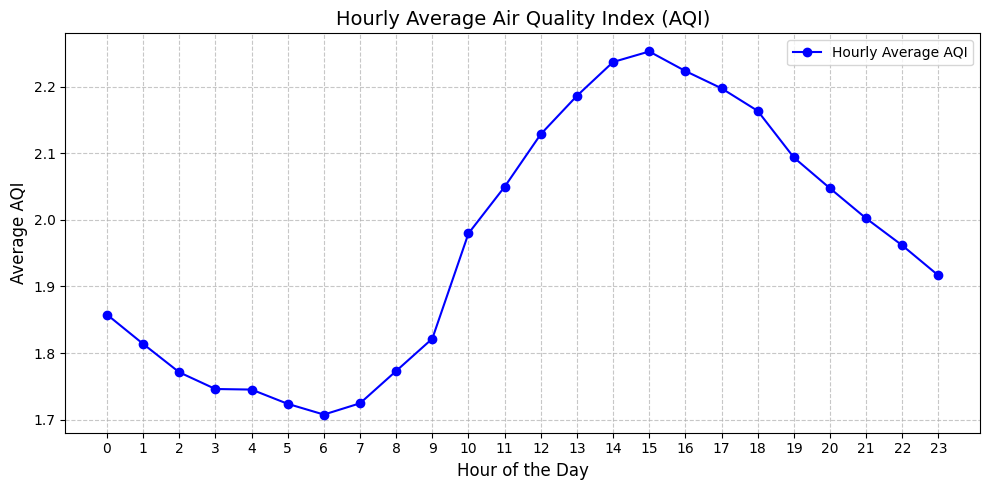

In [1014]:
hourly_avg = df.groupby("hour")["AQI"].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(hourly_avg["hour"], hourly_avg["AQI"], marker='o', linestyle='-', color='b', label='Hourly Average AQI')
plt.title("Hourly Average Air Quality Index (AQI)", fontsize=14)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Average AQI", fontsize=12)
plt.xticks(range(0, 24, 1), fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

Unlike the previous graphs, this one clearly shows a very distinct and strong diurnal (daily) trend. 

The AQI is at its **lowest in the early morning hours (around 6-7 AM)**, bottoming out between 1.7 and 1.75. It then shows a **steady and significant increase throughout the day**, reaching its **peak in the afternoon (between 2 PM and 4 PM)**, with the highest value around 2.25. Following the peak, the AQI **gradually decreases through the evening and night** until midnight. This cyclical pattern indicates that air quality is generally best in the early morning and tends to be worse during the afternoon.

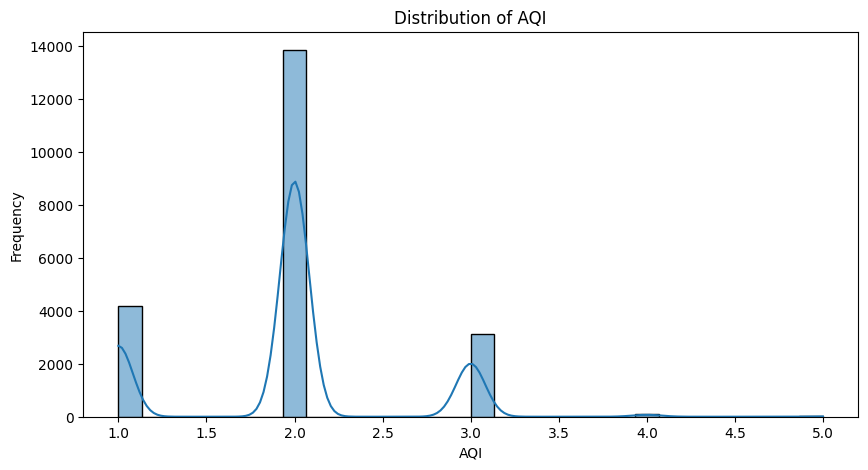

In [1015]:
plt.figure(figsize=(10,5))
seaborn.histplot(df['AQI'], bins=30, kde=True)
plt.title('Distribution of AQI')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

The histogram shows a **multi-modal distribution**, indicating that AQI values are concentrated around several distinct levels rather than being spread uniformly.

The most prominent mode (peak) is observed around an AQI value of **2.0**, which is by far the most frequent occurrence.

Higher AQI values (above 3) are observed very rarely, indicating that extremely poor air quality conditions are uncommon. This multi-modal pattern suggests that AQI values tend to cluster around specific states or conditions.

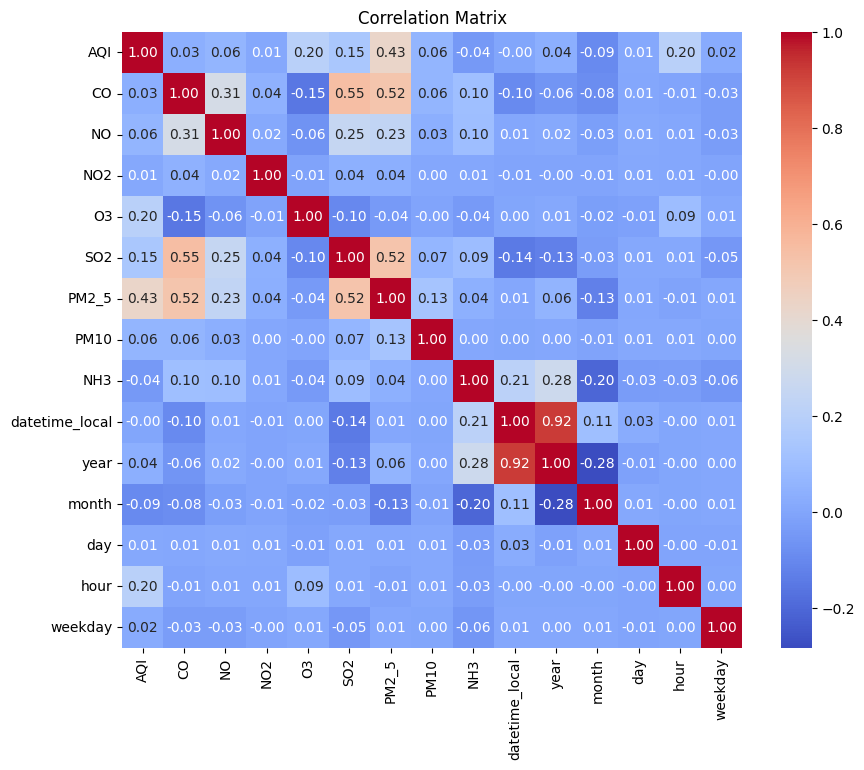

In [1016]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
seaborn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


- **Strongest Positive Correlation with PM2.5:** AQI shows the strongest positive correlation with **PM2.5 (0.43)**. This suggests that as PM2.5 levels increase, the AQI tends to increase significantly, indicating a strong influence of fine particulate matter on the overall Air Quality Index.
- **Moderate Positive Correlation with PM10 (0.20):** Similarly, PM10 also has a positive correlation with AQI, though not as strong as PM2.5.
- **Weak Positive Correlations:** AQI has weak positive correlations with **CO (0.03)**, **NO (0.06)** and **NO2 (0.04)**.
- **Weak Negative Correlations:** AQI shows weak negative correlations with **O3 (-0.20)**, **SO2 (-0.15)** and **NH3 (-0.04)**. The negative correlation with O3 is notable, suggesting that higher ozone levels might correspond to slightly lower overall AQI or vice-versa, which could be due to complex atmospheric chemistry or the way AQI is calculated from multiple pollutants.
- **Temporal Correlations with AQI:**
    - **Hour (0.20):** There's a notable positive correlation between AQI and the `hour` of the day. This aligns with the previous observation of higher AQI in the afternoon (as seen in the hourly average plot).
    - **Weekday (0.02):** Very weak positive correlation.
    - **Month (0.01) and Day (-0.01):** Almost no linear correlation.
    - **Year (-0.04):** Very weak negative correlation, suggesting a slight, almost negligible, decrease over the years captured.

- **PM2.5 & PM10:** As expected, PM2.5 and PM10 are positively correlated (**0.52**), indicating that their levels often rise and fall together.
- **CO & NO/NO2:** CO shows positive correlations with NO (**0.31**) and NO2 (**0.24**), which are common byproducts of combustion (e.g., vehicle emissions).
- **NO & NO2:** These two are strongly positively correlated (**0.70**), as NO can be oxidized to NO2 in the atmosphere.
- **O3:** O3 generally shows negative or very weak correlations with other primary pollutants like CO (-0.06), NO (-0.22), NO2 (-0.04), SO2 (-0.04), and PM2.5 (-0.04). This is often observed because O3 is a secondary pollutant formed from other precursors in the presence of sunlight, and its concentrations can sometimes be inversely related to primary emissions in certain conditions (e.g., titration by NO).
- **NH3:** NH3 has very weak or negligible correlations with most other pollutants, except for a weak positive correlation with PM2.5 (0.04) and PM10 (0.09), as ammonia can contribute to particulate matter formation.

In [1017]:
df = df.sort_values(by='datetime_local')

# list of lags (in hours) you want to create
lags = [1, 2, 3, 24, 168]

for lag in lags:
    df[f'AQI_lag_{lag}'] = df['AQI'].shift(lag)

df = df.dropna().reset_index(drop=True)

df

AQI      CO   NO   NO2     O3   SO2  PM2_5   PM10   NH3 datetime_local  \
0      2.0  233.65  0.0  1.37  60.08  1.22   1.78   2.35  0.05     2023-01-08   
1      2.0  233.65  0.0  1.22  63.66  1.16   1.83   2.37  0.04     2023-01-08   
2      1.0  250.34  0.0  2.63  49.35  1.68   3.28   3.79  0.07     2023-01-08   
3      1.0  243.66  0.0  1.91  52.93  1.40   2.21   2.75  0.08     2023-01-08   
4      1.0  247.00  0.0  2.29  50.78  1.56   2.67   3.17  0.08     2023-01-08   
...    ...     ...  ...   ...    ...   ...    ...    ...   ...            ...   
21093  1.0  125.38  0.0  3.03  56.35  1.31   8.21  10.19  2.77     2025-06-25   
21094  1.0  124.73  0.0  3.43  57.67  1.28   8.19  10.18  2.77     2025-06-25   
21095  1.0  125.83  0.0  3.97  54.44  1.17   8.15  10.13  2.95     2025-06-25   
21096  1.0  126.58  0.0  2.67  55.99  1.37   8.21  10.21  2.75     2025-06-25   
21097  1.0  126.65  0.0  2.10  56.72  1.34   8.04  10.12  2.59     2025-06-25   

       year  month  day  hour  weekday  AQI_lag_1  AQI_lag_2  AQI_lag_3  \
0      2023      1    8    22        7        1.0        1.0        1.0   
1      2023      1    8    23        7        2.0        1.0        1.0   
2      2023      1    8    18        7        2.0        2.0        1.0   
3      2023      1    8    20        7        1.0        2.0        2.0   
4      2023      1    8    19        7        1.0        1.0        2.0   
...     ...    ...  ...   ...      ...        ...        ...        ...   
21093  2025      6   25     2        3        1.0        1.0        1.0   
21094  2025      6   25     1        3        1.0        1.0        1.0   
21095  2025      6   25     0        3        1.0        1.0        1.0   
21096  2025      6   25     3        3        1.0        1.0        1.0   
21097  2025      6   25     5        3        1.0        1.0        1.0   

       AQI_lag_24  AQI_lag_168  
0             1.0          2.0  
1             1.0          2.0  
2             1.0          2.0  
3             1.0          2.0  
4             1.0          2.0  
...           ...          ...  
21093         2.0          1.0  
21094         3.0          1.0  
21095         3.0          1.0  
21096         3.0          1.0  
21097         2.0          1.0  

[21098 rows x 20 columns]

Creating lag features is a powerful and essential technique in time series analysis. For AQI it allows models to leverage past information, capture temporal dependencies and improve forecasting accuracy. This approach is widely used in both classical statistical models and modern machine learning pipelines for time series prediction.

## Target variable 🎯

In [1018]:
y = df['AQI']
X = df[['day', 'month', 'hour', 'AQI_lag_1', 'AQI_lag_2', 'AQI_lag_3', 'AQI_lag_24', 'AQI_lag_168']]

## Splitting into train/test 🪓
We will use 80% of the data for training and the rest - 20% for testing. This split allows the model to learn from the majority of the data while keeping a separate portion to evaluate its performance on unseen examples, helping us measure how well it generalizes.

In [1019]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 21098 observations, of which 16878 are now in the train set and 4220 in the test set.


## Modelling 🧬

In [1020]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Bagging': BaggingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'LGBM': LGBMRegressor(force_col_wise=True, verbose=-1),
    'CatBoost': CatBoostRegressor(verbose=0)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append((name, mae, mse, r2))

results_df = pandas.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'R²'])
results_df = results_df.sort_values('MAE')

results_df

Model       MAE       MSE        R²
2             XGBoost  0.285968  0.172386  0.539287
10               LGBM  0.286280  0.172264  0.539613
11           CatBoost  0.288403  0.168558  0.549518
1       Random Forest  0.292294  0.185745  0.503586
6                 SVR  0.293169  0.213539  0.429305
7                 KNN  0.297773  0.195479  0.477571
5             Bagging  0.298401  0.201563  0.461309
4         Extra Trees  0.304192  0.216651  0.420988
3   Gradient Boosting  0.305445  0.183655  0.509171
0   Linear Regression  0.323984  0.207474  0.445514
8               Ridge  0.323991  0.207474  0.445513
9               Lasso  0.379244  0.374184 -0.000030

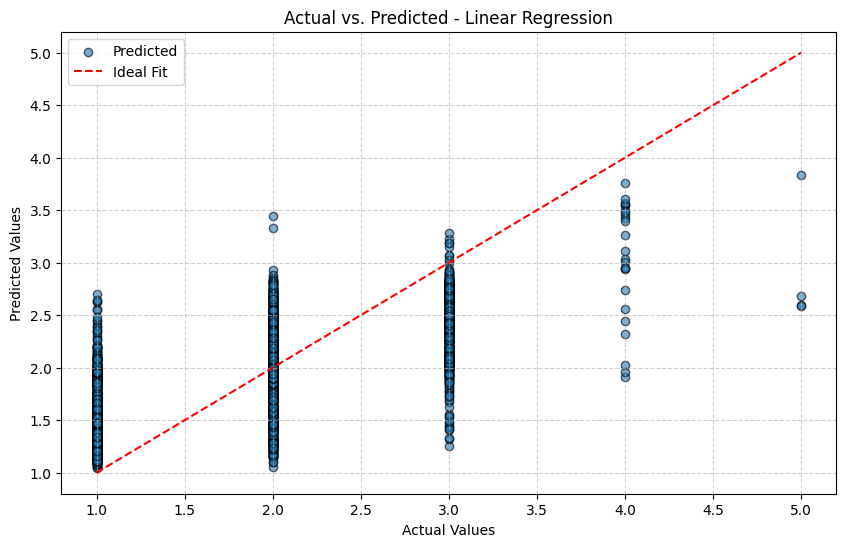

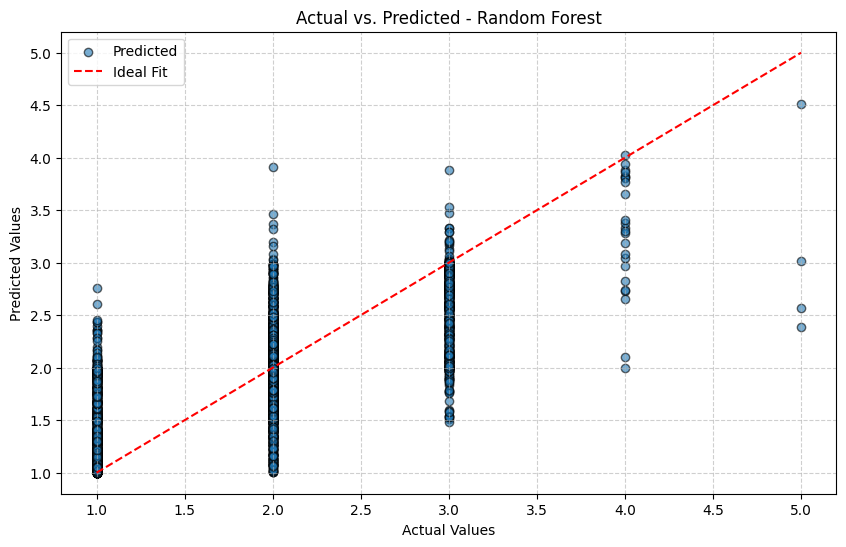

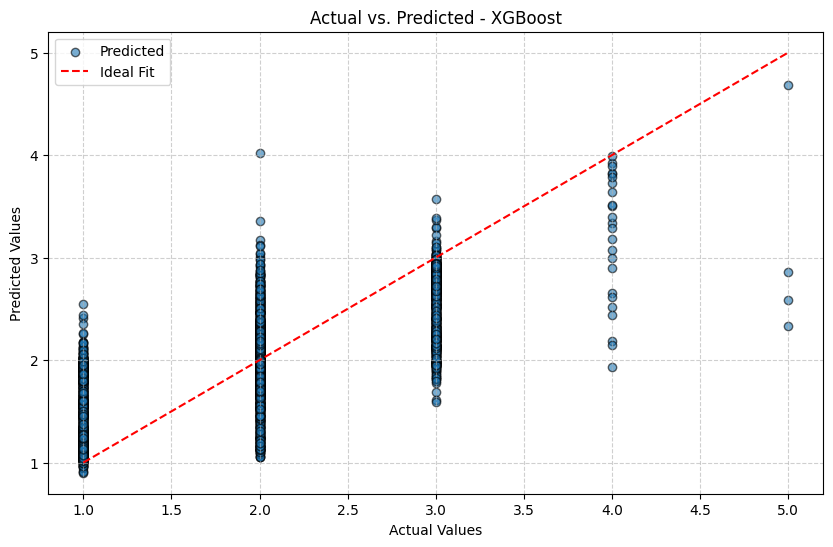

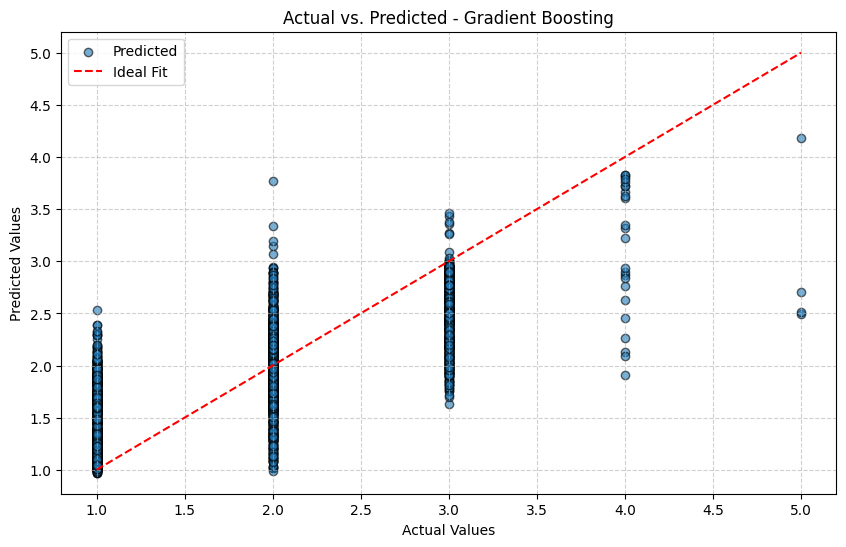

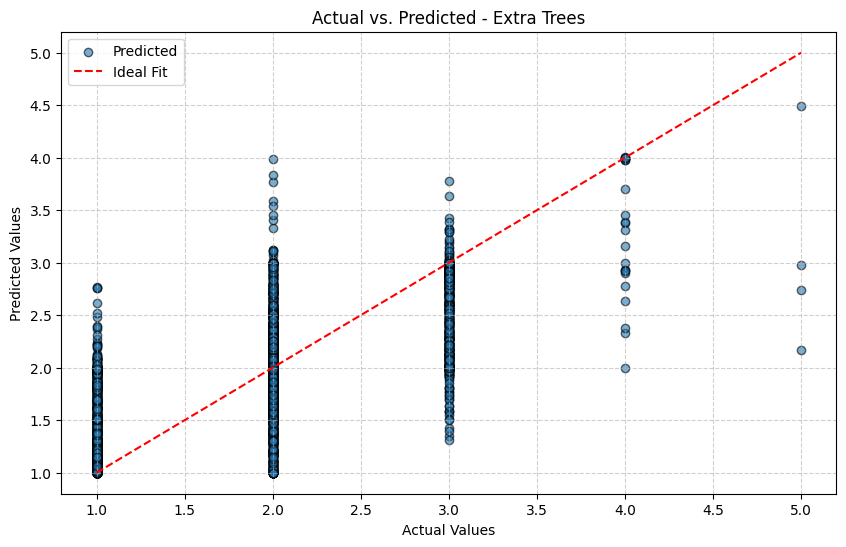

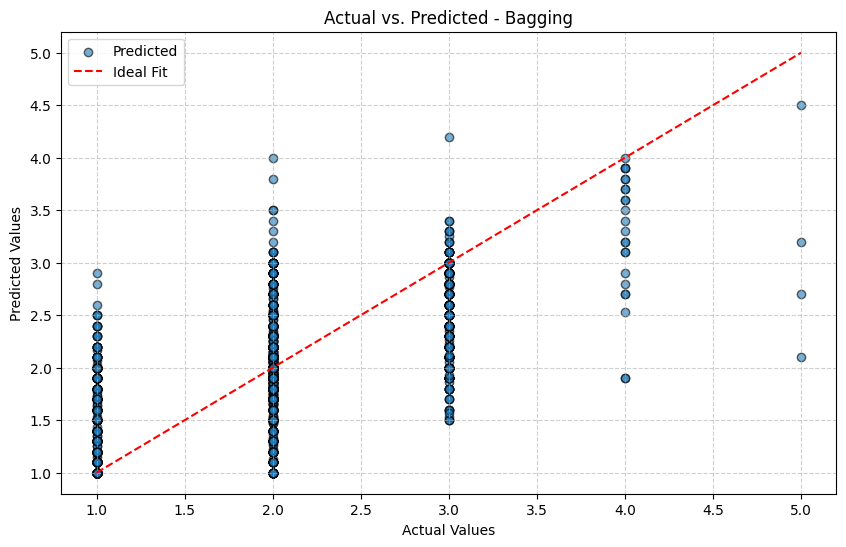

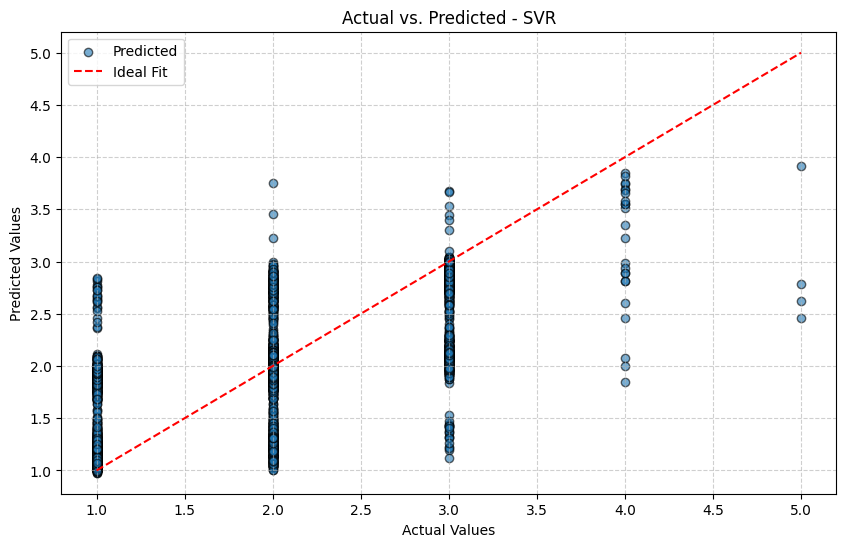

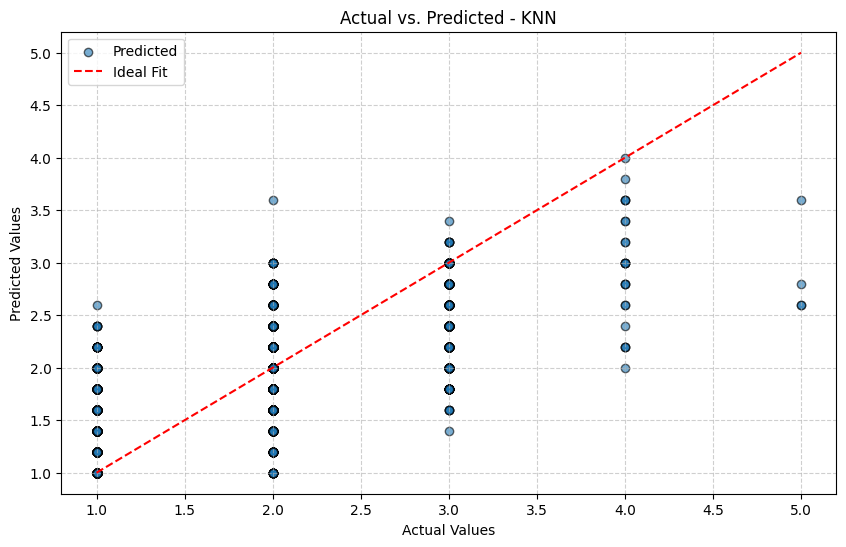

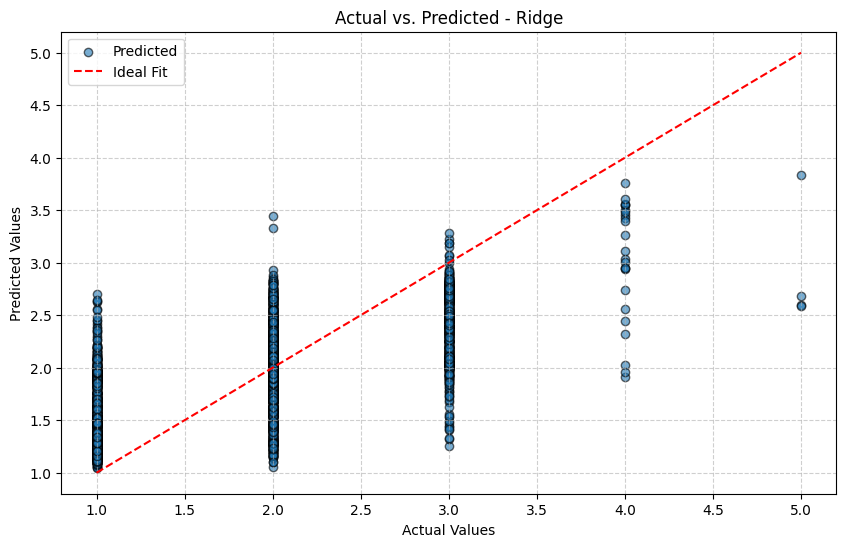

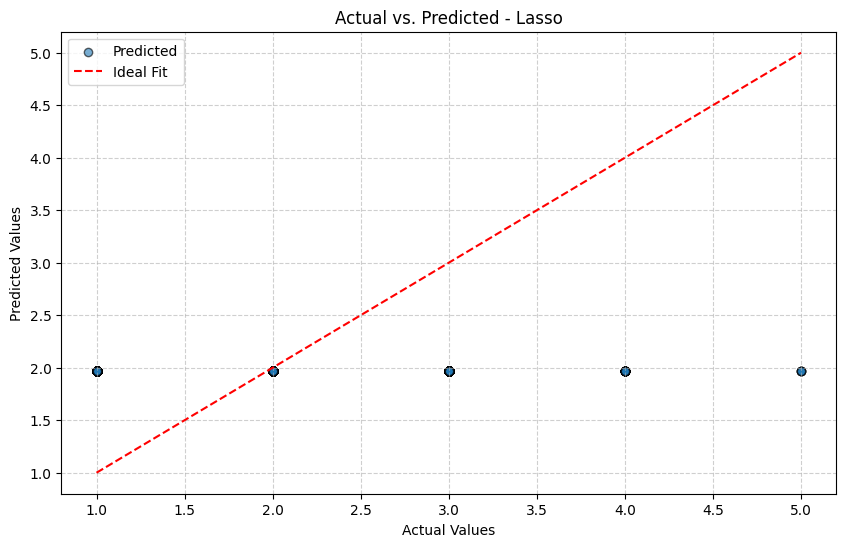

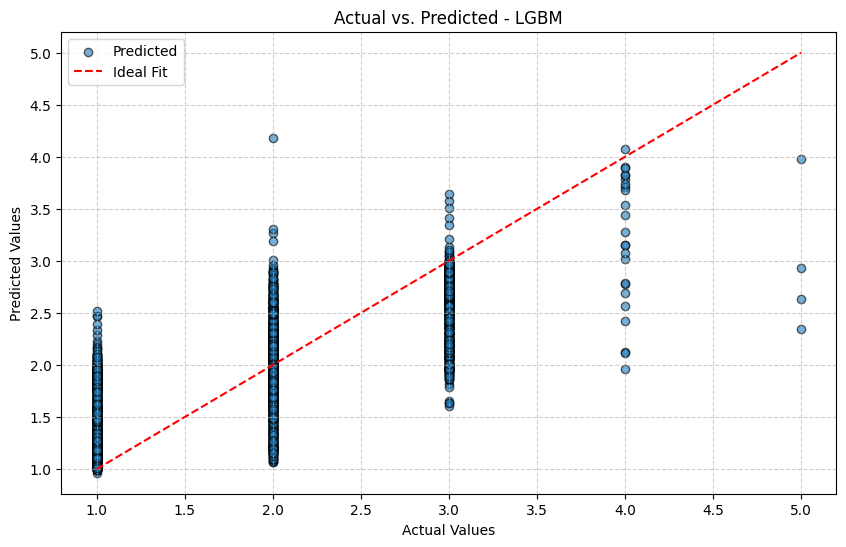

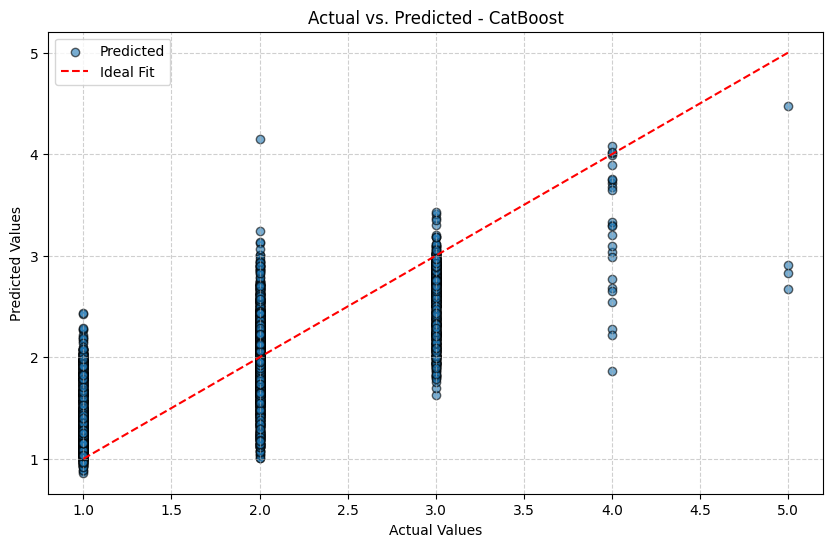

In [1021]:
for name, model in models.items():
    preds = model.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, alpha=0.6, edgecolor='k', label='Predicted')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit')
    plt.title(f"Actual vs. Predicted - {name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Previous Approach 🔙
Initially, I approached the project using OpenAQ [https://openaq.org/]. However, I found a better API source, so I am discarding this part of the project but keeping it as proof of my work. As there was a huge gap of data between the years.

## Data provisioning 📦

Next, we will use an API key provided by OpenAQ [https://openaq.org/] to check the what Air Monitoring Stations are available in Varna, Bulgaria.

In [1022]:
url = "https://api.openaq.org/v3/locations"
headers = {
    "X-API-Key": "c1061fd64a9bd88562b4bb823b7900ccdfd263a9a7aa54614de834dac611a4ca"
}
params = {
    "coordinates": "43.224389,27.915733",  # center of Varna
    "radius": 5000                         # 5 km radius
}

response = requests.get(url, headers=headers, params=params)

data = response.json().get("results", [])
df_nearby_stations = pandas.DataFrame(data)

print(df_nearby_stations[["id", "name", "locality"]])

        id                         name              locality
0     8843  AMS SOU Angel Kanchev-Varna                 Варна
1  2162113           AMS Chaika - Varna  National air network


Now that the IDs of each location are displayed, I can access each station's sensors to obtain the measurements.

### Angel Kanchev-Varna (part 1)

In [1023]:
url = "https://api.openaq.org/v3/locations/8843/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest1 = pandas.DataFrame(results)

df_latest1

id        name                                          parameter  \
0    25777    o3 µg/m³  {'id': 3, 'name': 'o3', 'units': 'µg/m³', 'dis...   
1    25778   no2 µg/m³  {'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...   
2    25776  pm10 µg/m³  {'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...   
3    25779    co µg/m³  {'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...   
4    25774   so2 µg/m³  {'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...   
5    25775  pm25 µg/m³  {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...   
6  4272879    no µg/m³  {'id': 19843, 'name': 'no', 'units': 'µg/m³', ...   

                                       datetimeFirst  \
0  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
1  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
2  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
3  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
4  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
5  {'utc': '2020-04-20T18:00:00Z', 'local': '2020...   
6  {'utc': '2023-03-29T18:00:00Z', 'local': '2023...   

                                        datetimeLast  \
0  {'utc': '2025-06-26T23:00:00Z', 'local': '2025...   
1  {'utc': '2025-06-26T23:00:00Z', 'local': '2025...   
2  {'utc': '2025-06-26T23:00:00Z', 'local': '2025...   
3  {'utc': '2025-06-26T23:00:00Z', 'local': '2025...   
4  {'utc': '2025-06-26T23:00:00Z', 'local': '2025...   
5  {'utc': '2025-06-26T23:00:00Z', 'local': '2025...   
6  {'utc': '2024-03-11T11:00:00Z', 'local': '2024...   

                                            coverage  \
0  {'expectedCount': 1, 'expectedInterval': '01:0...   
1  {'expectedCount': 1, 'expectedInterval': '01:0...   
2  {'expectedCount': 1, 'expectedInterval': '01:0...   
3  {'expectedCount': 1, 'expectedInterval': '01:0...   
4  {'expectedCount': 1, 'expectedInterval': '01:0...   
5  {'expectedCount': 1, 'expectedInterval': '01:0...   
6  {'expectedCount': 1, 'expectedInterval': '01:0...   

                                              latest  \
0  {'datetime': {'utc': '2025-06-26T23:00:00Z', '...   
1  {'datetime': {'utc': '2025-06-26T23:00:00Z', '...   
2  {'datetime': {'utc': '2025-06-26T23:00:00Z', '...   
3  {'datetime': {'utc': '2025-06-26T23:00:00Z', '...   
4  {'datetime': {'utc': '2025-06-26T23:00:00Z', '...   
5  {'datetime': {'utc': '2025-06-26T23:00:00Z', '...   
6  {'datetime': {'utc': '2024-03-11T11:00:00Z', '...   

                                             summary  
0  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
1  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
2  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
3  {'min': -1000.0, 'q02': None, 'q25': None, 'me...  
4  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
5  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
6  {'min': 0.14, 'q02': None, 'q25': None, 'media...

In [1024]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Angel Kanchev
sensor_ids = [25777, 25778, 25776, 25779, 25774, 25775, 4272879]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df1 = pandas.DataFrame(results)

        df1 = df1.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df1['period'].apply(lambda x: x['datetimeFrom']['utc'] if x else None),
            datetime_from_local=df1['period'].apply(lambda x: x['datetimeFrom']['local'] if x else None),
            datetime_to_utc=df1['period'].apply(lambda x: x['datetimeTo']['utc'] if x else None),
            datetime_to_local=df1['period'].apply(lambda x: x['datetimeTo']['local'] if x else None),
            parameter_name=df1['parameter'].apply(lambda x: x.get('name') if isinstance(x, dict) else None),
            parameter_units=df1['parameter'].apply(lambda x: x.get('units') if isinstance(x, dict) else None)
        ).drop(columns=['flagInfo', 'parameter', 'period', 'summary', 'coverage', 'coordinates'])

        sensor_data_frames.append(df1)

df1 = pandas.concat(sensor_data_frames, ignore_index=True)
df1

value  sensor_id     datetime_from_utc        datetime_from_local  \
0    56.93      25777  2020-04-20T17:00:00Z  2020-04-20T20:00:00+03:00   
1    25.44      25777  2020-04-20T18:00:00Z  2020-04-20T21:00:00+03:00   
2    23.04      25777  2020-04-20T19:00:00Z  2020-04-20T22:00:00+03:00   
3    30.51      25777  2020-04-20T20:00:00Z  2020-04-20T23:00:00+03:00   
4    25.95      25777  2020-04-20T21:00:00Z  2020-04-21T00:00:00+03:00   
..     ...        ...                   ...                        ...   
695  14.49    4272879  2023-04-02T16:00:00Z  2023-04-02T19:00:00+03:00   
696   1.68    4272879  2023-04-02T17:00:00Z  2023-04-02T20:00:00+03:00   
697   1.76    4272879  2023-04-02T18:00:00Z  2023-04-02T21:00:00+03:00   
698   2.85    4272879  2023-04-02T19:00:00Z  2023-04-02T22:00:00+03:00   
699   6.85    4272879  2023-04-02T20:00:00Z  2023-04-02T23:00:00+03:00   

          datetime_to_utc          datetime_to_local parameter_name  \
0    2020-04-20T18:00:00Z  2020-04-20T21:00:00+03:00             o3   
1    2020-04-20T19:00:00Z  2020-04-20T22:00:00+03:00             o3   
2    2020-04-20T20:00:00Z  2020-04-20T23:00:00+03:00             o3   
3    2020-04-20T21:00:00Z  2020-04-21T00:00:00+03:00             o3   
4    2020-04-20T22:00:00Z  2020-04-21T01:00:00+03:00             o3   
..                    ...                        ...            ...   
695  2023-04-02T17:00:00Z  2023-04-02T20:00:00+03:00             no   
696  2023-04-02T18:00:00Z  2023-04-02T21:00:00+03:00             no   
697  2023-04-02T19:00:00Z  2023-04-02T22:00:00+03:00             no   
698  2023-04-02T20:00:00Z  2023-04-02T23:00:00+03:00             no   
699  2023-04-02T21:00:00Z  2023-04-03T00:00:00+03:00             no   

    parameter_units  
0             µg/m³  
1             µg/m³  
2             µg/m³  
3             µg/m³  
4             µg/m³  
..              ...  
695           µg/m³  
696           µg/m³  
697           µg/m³  
698           µg/m³  
699           µg/m³  

[700 rows x 8 columns]

### AMS Chaika - Varna (part 1)
Let's do the same for this station as well.

In [1025]:
url = "https://api.openaq.org/v3/locations/2162113/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest2 = pandas.DataFrame(results)

df_latest2

id        name                                          parameter  \
0  7774820    no µg/m³  {'id': 19843, 'name': 'no', 'units': 'µg/m³', ...   
1  7774916   so2 µg/m³  {'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...   
2  7775044    co µg/m³  {'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...   
3  7775045   no2 µg/m³  {'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...   
4  8613114  pm10 µg/m³  {'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...   

                                       datetimeFirst  \
0  {'utc': '2024-01-28T23:00:00Z', 'local': '2024...   
1  {'utc': '2024-01-28T23:00:00Z', 'local': '2024...   
2  {'utc': '2024-01-28T23:00:00Z', 'local': '2024...   
3  {'utc': '2024-01-28T23:00:00Z', 'local': '2024...   
4  {'utc': '2024-03-18T07:00:00Z', 'local': '2024...   

                                        datetimeLast  \
0  {'utc': '2024-03-11T11:00:00Z', 'local': '2024...   
1  {'utc': '2025-06-26T23:00:00Z', 'local': '2025...   
2  {'utc': '2025-06-26T23:00:00Z', 'local': '2025...   
3  {'utc': '2025-06-26T23:00:00Z', 'local': '2025...   
4  {'utc': '2024-06-06T06:00:00Z', 'local': '2024...   

                                            coverage  \
0  {'expectedCount': 1, 'expectedInterval': '01:0...   
1  {'expectedCount': 1, 'expectedInterval': '01:0...   
2  {'expectedCount': 1, 'expectedInterval': '01:0...   
3  {'expectedCount': 1, 'expectedInterval': '01:0...   
4  {'expectedCount': 1, 'expectedInterval': '01:0...   

                                              latest  \
0  {'datetime': {'utc': '2024-03-11T11:00:00Z', '...   
1  {'datetime': {'utc': '2025-06-26T23:00:00Z', '...   
2  {'datetime': {'utc': '2025-06-26T23:00:00Z', '...   
3  {'datetime': {'utc': '2025-06-26T23:00:00Z', '...   
4  {'datetime': {'utc': '2024-06-06T06:00:00Z', '...   

                                             summary  
0  {'min': 1.36, 'q02': None, 'q25': None, 'media...  
1  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
2  {'min': -1000.0, 'q02': None, 'q25': None, 'me...  
3  {'min': -1.0, 'q02': None, 'q25': None, 'media...  
4  {'min': -1.0, 'q02': None, 'q25': None, 'media...

In [1026]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Chaika
sensor_ids = [7774820, 7774916, 7775044, 7775045, 8613114]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df2 = pandas.DataFrame(results)

        df2 = df2.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df2['period'].apply(lambda x: x['datetimeFrom']['utc'] if x else None),
            datetime_from_local=df2['period'].apply(lambda x: x['datetimeFrom']['local'] if x else None),
            datetime_to_utc=df2['period'].apply(lambda x: x['datetimeTo']['utc'] if x else None),
            datetime_to_local=df2['period'].apply(lambda x: x['datetimeTo']['local'] if x else None),
            parameter_name=df2['parameter'].apply(lambda x: x.get('name') if isinstance(x, dict) else None),
            parameter_units=df2['parameter'].apply(lambda x: x.get('units') if isinstance(x, dict) else None)
        ).drop(columns=['flagInfo', 'parameter', 'period', 'summary', 'coverage', 'coordinates'])

        sensor_data_frames.append(df2)

df2 = pandas.concat(sensor_data_frames, ignore_index=True)
df2

value  sensor_id     datetime_from_utc        datetime_from_local  \
0     1.51    7774820  2024-01-28T22:00:00Z  2024-01-29T00:00:00+02:00   
1     1.65    7774820  2024-01-28T23:00:00Z  2024-01-29T01:00:00+02:00   
2     1.54    7774820  2024-01-29T00:00:00Z  2024-01-29T02:00:00+02:00   
3     1.62    7774820  2024-01-29T01:00:00Z  2024-01-29T03:00:00+02:00   
4     1.66    7774820  2024-01-29T02:00:00Z  2024-01-29T04:00:00+02:00   
..     ...        ...                   ...                        ...   
495  -1.00    8613114  2024-03-29T19:00:00Z  2024-03-29T21:00:00+02:00   
496  -1.00    8613114  2024-03-29T20:00:00Z  2024-03-29T22:00:00+02:00   
497  -1.00    8613114  2024-03-29T21:00:00Z  2024-03-29T23:00:00+02:00   
498  -1.00    8613114  2024-03-29T22:00:00Z  2024-03-30T00:00:00+02:00   
499  -1.00    8613114  2024-03-29T23:00:00Z  2024-03-30T01:00:00+02:00   

          datetime_to_utc          datetime_to_local parameter_name  \
0    2024-01-28T23:00:00Z  2024-01-29T01:00:00+02:00             no   
1    2024-01-29T00:00:00Z  2024-01-29T02:00:00+02:00             no   
2    2024-01-29T01:00:00Z  2024-01-29T03:00:00+02:00             no   
3    2024-01-29T02:00:00Z  2024-01-29T04:00:00+02:00             no   
4    2024-01-29T03:00:00Z  2024-01-29T05:00:00+02:00             no   
..                    ...                        ...            ...   
495  2024-03-29T20:00:00Z  2024-03-29T22:00:00+02:00           pm10   
496  2024-03-29T21:00:00Z  2024-03-29T23:00:00+02:00           pm10   
497  2024-03-29T22:00:00Z  2024-03-30T00:00:00+02:00           pm10   
498  2024-03-29T23:00:00Z  2024-03-30T01:00:00+02:00           pm10   
499  2024-03-30T00:00:00Z  2024-03-30T02:00:00+02:00           pm10   

    parameter_units  
0             µg/m³  
1             µg/m³  
2             µg/m³  
3             µg/m³  
4             µg/m³  
..              ...  
495           µg/m³  
496           µg/m³  
497           µg/m³  
498           µg/m³  
499           µg/m³  

[500 rows x 8 columns]

The next step is to combine both datasets, as we have the latest measurements from both stations.

In [1027]:
combined_df = pandas.concat([df1, df2], ignore_index=True)

print("The API key dataset from the 2 stations contains: " + str(combined_df.shape))

The API key dataset from the 2 stations contains: (1200, 8)


While the current format might look decent, we have an issue with the data layout. Each row includes a value next to the parameter name, which means we do not have all pollutants listed on one row alongside the corresponding datetime. To resolve this, we will set the datetime as the index.

In [1028]:
combined_df = combined_df.pivot_table(
    index='datetime_from_local',
    columns='parameter_name',
    values='value'
).reset_index()

combined_df

parameter_name        datetime_from_local     co  no    no2     o3   pm10  \
0               2020-04-20T20:00:00+03:00  400.0 NaN  23.33  56.93  24.27   
1               2020-04-20T21:00:00+03:00  530.0 NaN  51.60  25.44  24.27   
2               2020-04-20T22:00:00+03:00  560.0 NaN  44.01  23.04  23.85   
3               2020-04-20T23:00:00+03:00  500.0 NaN  27.78  30.51  21.48   
4               2020-04-21T00:00:00+03:00  480.0 NaN  25.94  25.95  21.46   
..                                    ...    ...  ..    ...    ...    ...   
397             2024-03-29T21:00:00+02:00    NaN NaN    NaN    NaN  -1.00   
398             2024-03-29T22:00:00+02:00    NaN NaN    NaN    NaN  -1.00   
399             2024-03-29T23:00:00+02:00    NaN NaN    NaN    NaN  -1.00   
400             2024-03-30T00:00:00+02:00    NaN NaN    NaN    NaN  -1.00   
401             2024-03-30T01:00:00+02:00    NaN NaN    NaN    NaN  -1.00   

parameter_name   pm25    so2  
0               18.38  20.16  
1               19.34  19.85  
2               18.33  20.77  
3               17.23  20.10  
4               19.66  19.95  
..                ...    ...  
397               NaN    NaN  
398               NaN    NaN  
399               NaN    NaN  
400               NaN    NaN  
401               NaN    NaN  

[402 rows x 8 columns]

It is clear that not all sensors work simultaneously. To visualize all missing data, we will represent it through a heatmap.

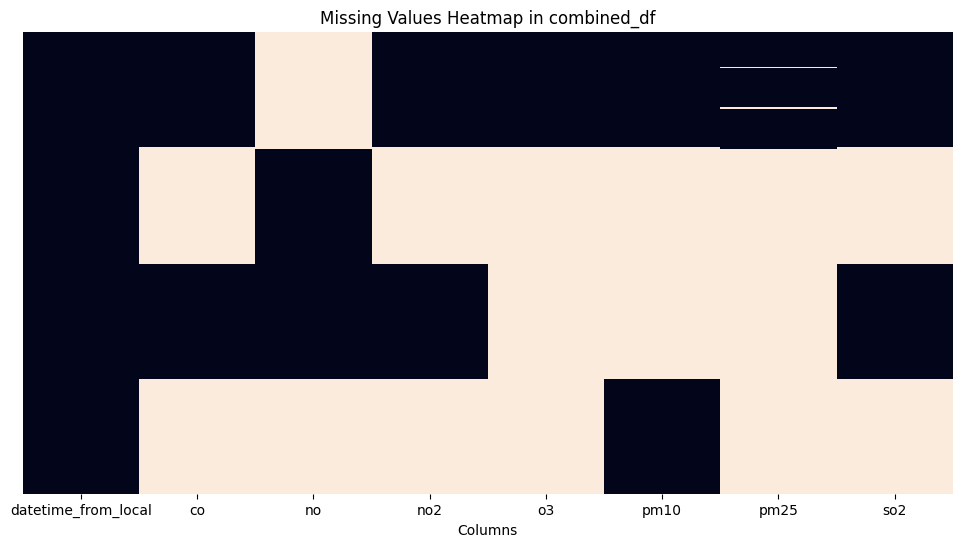

In [1029]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(combined_df.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in combined_df')
plt.xlabel('Columns')
plt.show()

In [1030]:
missing_percent = combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

parameter_name
pm25                   75.124378
o3                     75.124378
co                     50.248756
no                     50.248756
pm10                   50.248756
no2                    50.248756
so2                    50.248756
datetime_from_local     0.000000
dtype: float64


Due to the significant amount of missing data for all pollutants and considering there may be alternative ways to insert data through requests that I have not yet discovered after the first week of the open programme, I decided to download the available datasets for each month from each station for the year 2025. This will ensure that the data is more recent.

### AMS Chaika - Varna (part 2)

In [1031]:
chaika1 = pandas.read_csv('datasets/openaq_location_2162113_measurments.csv')
chaika1.shape

(3000, 15)

In [1032]:
chaika2 = pandas.read_csv('datasets/openaq_location_2162113_measurments (1).csv')
chaika2.shape

(1416, 15)

In [1033]:
chaika3 = pandas.read_csv('datasets/openaq_location_2162113_measurments (2).csv')
chaika3.shape

(1857, 15)

In [1034]:
chaika4 = pandas.read_csv('datasets/openaq_location_2162113_measurments (3).csv')
chaika4.shape

(1430, 15)

In [1035]:
chaika5 = pandas.read_csv('datasets/openaq_location_2162113_measurments (4).csv')
chaika5.shape

(1354, 15)

In [1036]:
chaika_dataset = pandas.concat([chaika1, chaika2, chaika3, chaika4, chaika5])

In [1037]:
chaika_dataset.shape

(9057, 15)

In [1038]:
chaika_dataset = chaika_dataset.pivot_table(
    index='datetimeLocal',
    columns='parameter',
    values='value'
).reset_index()

chaika_dataset

parameter              datetimeLocal      co    no2    so2
0          2025-01-01T20:00:00+02:00  1450.0  26.41  20.61
1          2025-01-02T01:00:00+02:00  1260.0  22.42   9.25
2          2025-01-02T02:00:00+02:00  1040.0  16.81   8.45
3          2025-01-02T11:00:00+02:00   940.0  22.20  11.81
4          2025-01-02T12:00:00+02:00   960.0  21.99  13.28
...                              ...     ...    ...    ...
3045       2025-06-19T05:00:00+03:00   560.0  12.22  -1.00
3046       2025-06-19T06:00:00+03:00   560.0  12.20  -1.00
3047       2025-06-19T07:00:00+03:00   540.0   8.39  -1.00
3048       2025-06-19T09:00:00+03:00   540.0  11.03  -1.00
3049       2025-06-20T01:00:00+03:00   500.0   8.16  -1.00

[3050 rows x 4 columns]

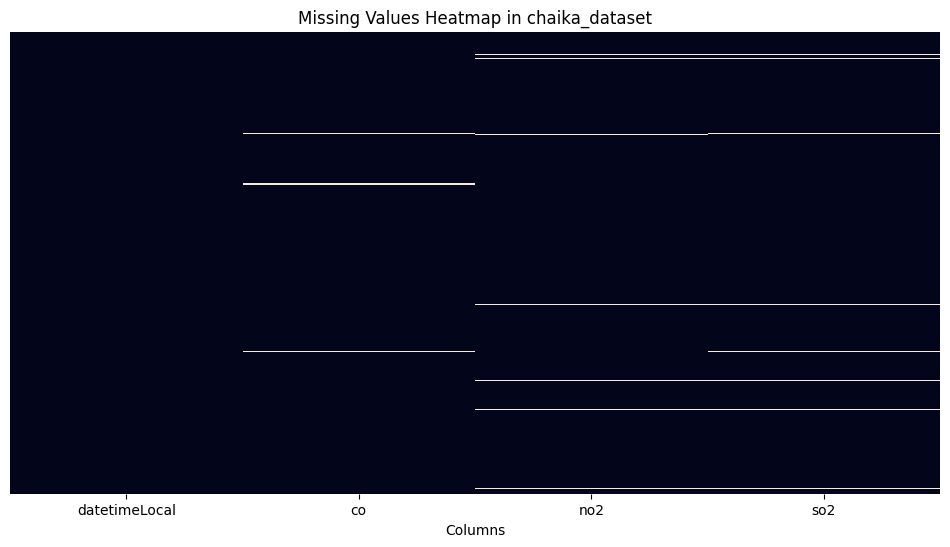

In [1039]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(chaika_dataset.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in chaika_dataset')
plt.xlabel('Columns')
plt.show()

What is noticeable here is that although there is little data missing, not all pollutants from the previous dataset are present.

### Angel Kanchev-Varna (part 2)
Let's do the same here for the next station.

In [1040]:
angel1 = pandas.read_csv('datasets/openaq_location_8843_measurments.csv')
angel1.shape

(6000, 15)

In [1041]:
angel2 = pandas.read_csv('datasets/openaq_location_8843_measurments (1).csv')
angel2.shape

(2829, 15)

In [1042]:
angel3 = pandas.read_csv('datasets/openaq_location_8843_measurments (2).csv')
angel3.shape

(3727, 15)

In [1043]:
angel4 = pandas.read_csv('datasets/openaq_location_8843_measurments (3).csv')
angel4.shape

(2871, 15)

In [1044]:
angel5 = pandas.read_csv('datasets/openaq_location_8843_measurments (4).csv')
angel5.shape

(2724, 15)

In [1045]:
angel_dataset = pandas.concat([angel1, angel2, angel3, angel4, angel5])

In [1046]:
angel_dataset.shape

(18151, 15)

In [1047]:
angel_dataset = angel_dataset.pivot_table(
    index='datetimeLocal',
    columns='parameter',
    values='value'
).reset_index()

angel_dataset

parameter              datetimeLocal      co     no2     o3   pm10   pm25  \
0          2025-01-01T20:00:00+02:00  1180.0   95.40   7.74  51.87  51.69   
1          2025-01-02T01:00:00+02:00   490.0   34.49  37.32  44.20  12.47   
2          2025-01-02T02:00:00+02:00   570.0   52.76  19.50  37.13  16.54   
3          2025-01-02T11:00:00+02:00   650.0   70.78  25.91  34.11  21.86   
4          2025-01-02T12:00:00+02:00   720.0   80.30  24.58  35.74  27.21   
...                              ...     ...     ...    ...    ...    ...   
3070       2025-06-19T05:00:00+03:00   350.0    7.46  50.75  10.97   5.82   
3071       2025-06-19T06:00:00+03:00   350.0    7.30  46.95   8.71   5.20   
3072       2025-06-19T07:00:00+03:00   330.0   15.55  41.18  12.10   5.40   
3073       2025-06-19T09:00:00+03:00   720.0  107.43   9.54  20.52   8.29   
3074       2025-06-20T01:00:00+03:00   370.0   46.84  31.60  25.07  12.71   

parameter    so2  
0          16.57  
1          16.00  
2          16.01  
3          16.45  
4          16.53  
...          ...  
3070       10.19  
3071       11.06  
3072       10.68  
3073       10.64  
3074       12.56  

[3075 rows x 7 columns]

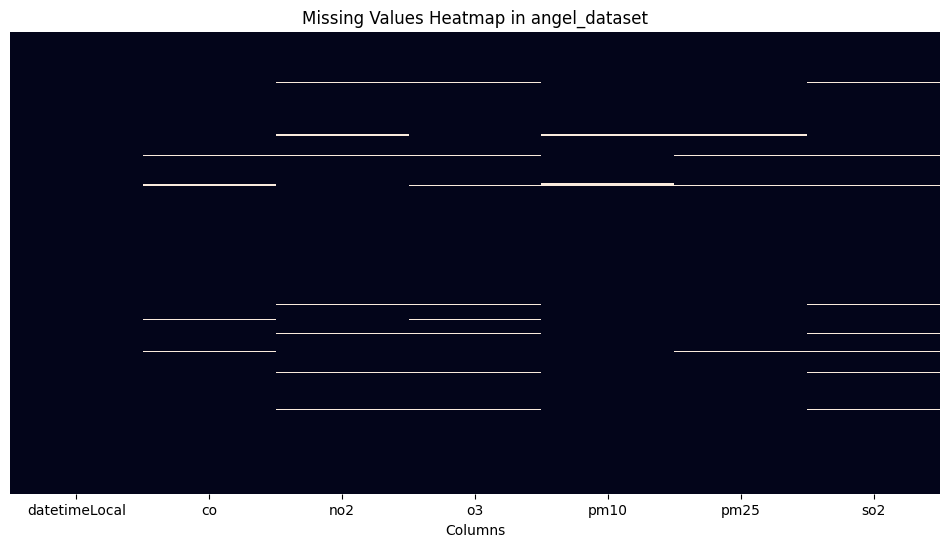

In [1048]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(angel_dataset.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in angel_dataset')
plt.xlabel('Columns')
plt.show()

Compared to the previous dataset from Chaika, there are more pollutants, but some are still missing. 

Let's combine all of them to see the final result.

## Combination of all CSV files 📥

In [1049]:
final_combined_df = pandas.concat([chaika_dataset, angel_dataset, combined_df])

In [1050]:
print("The API key and csv file datasets contain: " + str(final_combined_df.shape))

The API key and csv file datasets contain: (6527, 9)


In [1051]:
final_combined_df.sample(10)

datetimeLocal     co    no2    so2     o3   pm10   pm25  \
125   2025-01-07T16:00:00+02:00  720.0  11.70  16.59    NaN    NaN    NaN   
1100  2025-03-01T01:00:00+02:00  480.0  14.59  11.62  74.86  26.24  11.78   
214   2025-01-13T06:00:00+02:00  430.0   2.32  17.18  47.36  24.40  10.73   
930   2025-02-18T05:00:00+02:00  410.0   0.92  19.44  66.13  11.75   0.94   
439   2025-01-26T18:00:00+02:00  640.0   9.39   7.01    NaN    NaN    NaN   
2808  2025-06-01T07:00:00+03:00  340.0   3.15   8.44  54.57  19.18   6.81   
92    2025-01-06T06:00:00+02:00  660.0   9.25   7.39    NaN    NaN    NaN   
385                         NaN    NaN    NaN    NaN    NaN  -1.00    NaN   
1061  2025-02-24T16:00:00+02:00  500.0  15.24  24.94  80.47  20.65   6.85   
1749  2025-04-05T14:00:00+03:00  570.0  10.41   8.81    NaN    NaN    NaN   

            datetime_from_local  no  
125                         NaN NaN  
1100                        NaN NaN  
214                         NaN NaN  
930                         NaN NaN  
439                         NaN NaN  
2808                        NaN NaN  
92                          NaN NaN  
385   2024-03-29T09:00:00+02:00 NaN  
1061                        NaN NaN  
1749                        NaN NaN

## Data Dictionary 📖

Below is a **data dictionary** with descriptions for the final key variables used in this dataset:

| No. | Column Name                 | Unit                  | Description                                                                 |
|-----|-----------------------------|-----------------------|-----------------------------------------------------------------------------|
| 1   | `co`                        | parts per million(ppm)| Concentration of carbon monoxide (CO).                                      |
| 2   | `no2`                       | µg/m³                 | Concentration of nitrogen dioxide (NO₂).                                    |
| 3   | `so2`                       | µg/m³                 | Concentration of sulfur dioxide (SO₂).                                      |
| 4   | `o3`                        | µg/m³                 | Concentration of ozone (O₃).                                                |
| 5   | `pm10`                      | µg/m³                 | Concentration of particulate matter (PM₁₀).                                 |
| 6   | `pm25`                      | µg/m³                 | Concentration of particulate matter (PM₂.₅).                                |
| 7   | `no`                        | µg/m³                 | Concentration of nitrogen monoxide (NO).                                    |
| 8   | `datetimeLocal/datetime_from_local` | datetime      | Local date and time of the measurement.                                     |
| 9   | `AQI`                       | unitless              | Air Quality Index (AQI) value calculated based on pollutant concentrations. |
| 10  | `AQI_Category`              | categorical           | Qualitative category of air quality based on AQI values.                    |

⚠️ Not all variables were used in the final model. Several columns were excluded during the cleaning and feature selection process due to missing values, low variance, or low correlation with the target variable (see EDA section for justification).

## Preprocessing 🛠️

### Format dates 🗓️

It is evident that the columns "datetimeLocal" and "datetime_from_local" cannot co-exist since they represent the same data. Therefore, it is logical to combine them into a single column.

In [1052]:
final_combined_df['datetime_local'] = final_combined_df['datetime_from_local'].combine_first(final_combined_df['datetimeLocal'])
final_combined_df.drop(columns=['datetime_from_local', 'datetimeLocal'], inplace=True)

In [1053]:
final_combined_df.dtypes

co                float64
no2               float64
so2               float64
o3                float64
pm10              float64
pm25              float64
no                float64
datetime_local     object
dtype: object

In [1054]:
final_combined_df['datetime_local'] = pandas.to_datetime(final_combined_df['datetime_local'], utc=True)
print(final_combined_df.dtypes)

co                            float64
no2                           float64
so2                           float64
o3                            float64
pm10                          float64
pm25                          float64
no                            float64
datetime_local    datetime64[ns, UTC]
dtype: object


In [1055]:
final_combined_df['datetime_local'] = pandas.to_datetime(final_combined_df['datetime_local'], errors='coerce')
final_combined_df['datetime_local'] = final_combined_df['datetime_local'].dt.strftime('%Y-%m-%d %H:%M')

In [1056]:
final_combined_df.sample(10)

co    no2    so2     o3   pm10   pm25  no    datetime_local
548   460.0  22.87  18.82  19.57  34.17  17.55 NaN  2025-01-31 02:00
1821  710.0  14.80   8.22    NaN    NaN    NaN NaN  2025-04-09 01:00
1172  550.0  45.52  14.54  81.27  42.07  10.88 NaN  2025-03-07 14:00
3025  320.0   6.76   9.98  58.70  15.15   3.63 NaN  2025-06-14 09:00
2445  420.0   8.52   4.12  26.57   9.02   5.81 NaN  2025-05-13 02:00
49    450.0  20.56  16.07  37.77   7.00   2.00 NaN  2025-01-04 08:00
2104  450.0  33.88  10.82  35.69  13.23   4.28 NaN  2025-04-21 05:00
2756  400.0  51.65  10.79  45.45  28.33  10.99 NaN  2025-05-29 19:00
1041  930.0  24.89   7.97    NaN    NaN    NaN NaN  2025-02-24 08:00
1733  490.0   8.97   8.46    NaN    NaN    NaN NaN  2025-04-04 16:00

### Null values 0️⃣

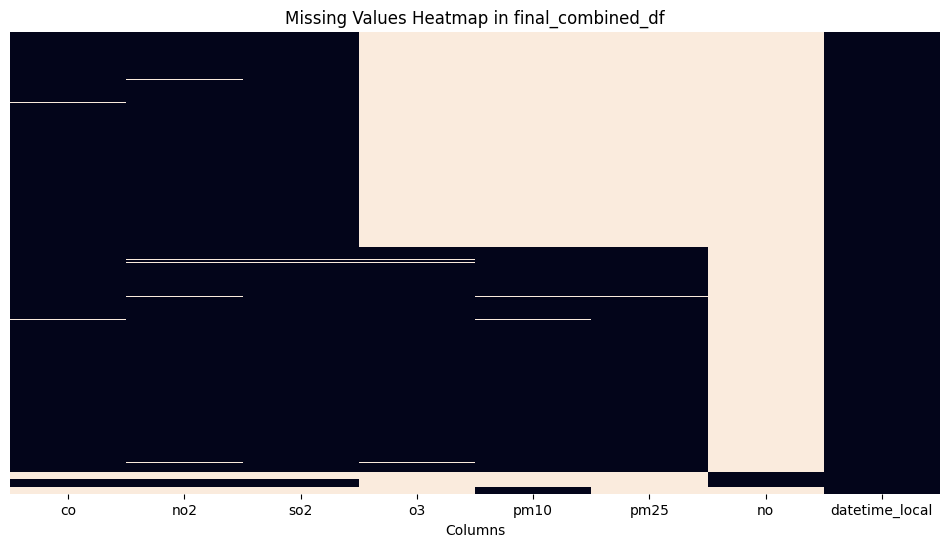

In [1057]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in final_combined_df')
plt.xlabel('Columns')
plt.show()

In [1058]:
missing_percent = final_combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

no                96.935805
o3                52.290486
pm25              52.014708
pm10              50.375364
no2                4.703539
so2                4.473725
co                 3.968132
datetime_local     0.000000
dtype: float64


Since **nitric oxide (NO)** is missing in nearly 97% of the dataset, I believe it is not very important and should not be included. I will only retain values that have a presence of more than 30% in the dataset, as those have a valid reason for being kept. Even partial data can capture trends or patterns.

To better understand each value, I will explain them one by one, chemical by chemical:

**PM2.5 (Fine Particulate Matter)**
- One of the most dangerous air pollutants. Often a major driver of AQI values.
- Can penetrate deep into the lungs and even enter the bloodstream. Linked to respiratory and cardiovascular diseases, premature death and cancer.

**PM10 (Inhalable Particulate Matter)**
- Can cause respiratory irritation, lung function decline and worsen conditions like asthma and bronchitis.

**O₃ (Ground-level Ozone)**
- Not emitted directly; formed by chemical reactions between NOx and VOCs in sunlight.
- Causes chest pain, coughing, throat irritation, and worsens asthma and other lung diseases.
- Major component of smog; more problematic during sunny, hot weather.

**SO₂ (Sulfur Dioxide)**
- Burning of coal and oil, especially from power plants and ships.
- Causes respiratory symptoms and aggravates conditions like asthma.
- Can lead to acid rain and contributes to PM formation; more of a concern in industrial areas or near ports.

**CO (Carbon Monoxide)**
- Incomplete combustion from cars, stoves and heaters.
- Reduces oxygen delivery in the body, can be fatal at very high levels; particularly dangerous indoors.
- Usually less of a concern outdoors unless near heavy traffic or in enclosed urban canyons.

**NO₂ (Nitrogen Dioxide)**
- Combustion engines (cars, trucks, etc), power plants.
- Irritates airways, reduces lung function, and increases the risk of respiratory infections.
- Key indicator of traffic-related air pollution; contributes to the formation of PM and ozone.

**NO (Nitric Oxide)**
- Emitted directly from vehicles and industrial activity.
- Less directly harmful, but quickly converts into **NO₂**, which is more dangerous.

So since we have enough of the **NO₂**, discarding **NO** is fine, due to the following reasons:
- **NO** and **NO₂** are chemically linked and often reported together as NOx (nitrogen oxides).
- **NO₂** is the more harmful and relevant pollutant for health and AQI. It is usually used directly in AQI calculation, not **NO**.
- **NO** is a precursor to **NO₂** and ozone, but if you already have **NO₂** (which reflects both traffic-related emissions and photochemical activity), we are already capturing the more critical part of the picture.

sources: 
- https://ww2.arb.ca.gov/resources/nitrogen-dioxide-and-health#:~:text=Air%20quality%20regulators%20have%20selected,X%20emissions%20as%20a%20group
- https://en.wikipedia.org/wiki/NOx#:~:text=In%20atmospheric%20chemistry%2C%20the%20term,to%20again%20form%20NO%202

In [1059]:
threshold = 0.7
final_combined_df = final_combined_df.loc[:, final_combined_df.isnull().mean() < threshold]

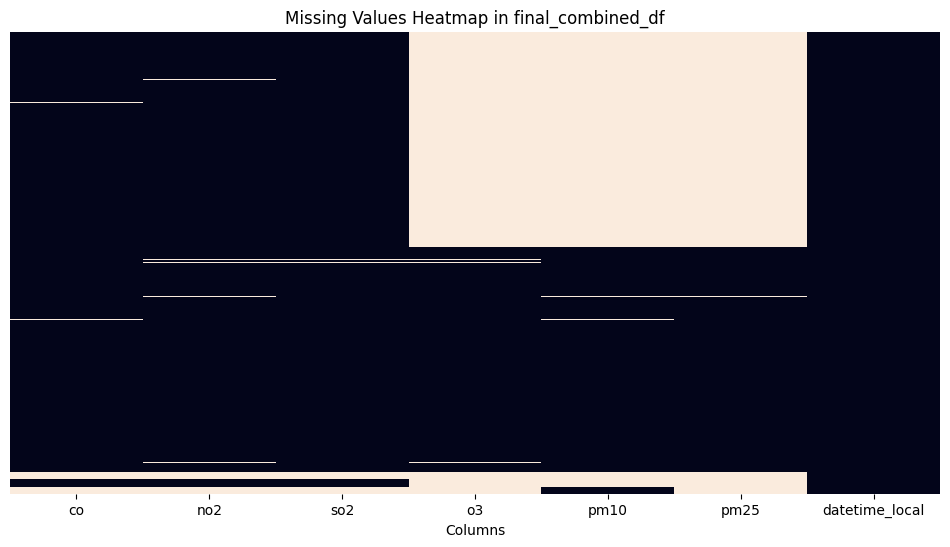

In [1060]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap='rocket', 
            yticklabels=False)

plt.title('Missing Values Heatmap in final_combined_df')
plt.xlabel('Columns')
plt.show()

In [1061]:
final_combined_df.sample(10)

co    no2    so2     o3   pm10   pm25    datetime_local
1199  840.0  14.08   7.56    NaN    NaN    NaN  2025-03-09 08:00
1340  590.0   9.46  10.92    NaN    NaN    NaN  2025-03-16 06:00
1551  480.0  70.80  10.29  38.55  25.92  11.01  2025-03-25 06:00
2298  510.0   9.63  12.13    NaN    NaN    NaN  2025-05-07 02:00
387     NaN    NaN    NaN    NaN  -1.00    NaN  2024-03-29 09:00
1270  590.0  12.61   8.83    NaN    NaN    NaN  2025-03-12 18:00
1303  680.0  13.47   8.34    NaN    NaN    NaN  2025-03-14 10:00
2904  440.0   6.00  -1.00    NaN    NaN    NaN  2025-06-07 12:00
2341  490.0  12.23  11.91    NaN    NaN    NaN  2025-05-09 08:00
39    380.0  20.30  19.49  62.83  33.34  14.25  2020-04-22 17:00

Since several key features like **O₃**, **PM2.5** and **PM10** have more than 50% missing values, we apply mean imputation to handle missing values in key pollutant features, ensuring dataset completeness while preserving the overall data distribution for model training.

In [1062]:
# imputer = SimpleImputer(strategy='mean') 
# final_combined_df[['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']] = imputer.fit_transform(
#     final_combined_df[['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']]
# )

After testing the models, I found overfitting due to imputation. To prevent this, I decided to drop the non-value data instead. That is why I commented the block of code.

In [1063]:
final_combined_df = final_combined_df.dropna(subset=['co', 'no2', 'so2', 'o3', 'pm10', 'pm25'])

In [1064]:
final_combined_df.isnull().sum()

co                0
no2               0
so2               0
o3                0
pm10              0
pm25              0
datetime_local    0
dtype: int64

Finally, here is the result no missing values.

The issue with the missing data arises from the outdated measurments provided by the API key, as well as the fact that both stations do not collect the same measurements. To address this, I utilized the CSV files. The data for 2025 is much more complete and up-to-date, making it a better choice for the model and the final results.

## Sample the data 📃

In [1065]:
final_combined_df.sample(10)

co     no2    so2     o3   pm10   pm25    datetime_local
60     670.0   83.41  16.13  19.28  13.99  21.74  2025-01-04 19:00
2506   440.0   12.05   5.42  70.87  24.28   7.53  2025-05-15 21:00
498   1030.0  104.39  18.23   5.78  69.43  28.58  2025-01-28 19:00
1748   400.0    9.39   9.77  77.47  24.95   9.55  2025-04-04 16:00
2041   410.0   10.75  10.07  87.76  11.29   3.73  2025-04-18 08:00
1457 -1000.0   -1.00  -1.00  -1.00  -1.00  -1.00  2025-03-21 00:00
503    400.0   19.04  18.46  36.52  32.65  11.37  2025-01-29 01:00
436    660.0   37.82  18.08  11.27  25.90  22.91  2025-01-26 02:00
761    410.0    4.10  20.01  46.88  17.63  13.43  2025-02-10 06:00
1200   930.0  121.53  14.46  18.72  44.61  34.00  2025-03-08 19:00

## Calculating AQI 🧮
At the moment there is no present target variable from this data, however the data is enough to calculate the AQI sub-index for a given pollutant concentration, based on a list of breakpoint ranges. Then, it rounds the result to the nearest whole number (since AQI is usually reported as an integer). If no breakpoint matches, it returns None

In [1066]:
def get_subindex(concentration, breakpoints):
    for Clow, Chigh, Ilow, Ihigh in breakpoints:
        if Clow <= concentration <= Chigh:
            return round((Ihigh - Ilow) / (Chigh - Clow) * (concentration - Clow) + Ilow)
    return None

The following block defines breakpoints for the air pollutants. These are used to map pollutant concentration levels to AQI sub-index values, according to air quality standards. 

Each list of breakpoints contains tuples with 4 values:

**(Concentration_low, Concentration_high, AQI_low, AQI_high)**

These represent a range of pollutant concentration values and the corresponding AQI values.

I got it from United States Environmental Protection Agency (https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html)

In [1067]:
pm25_breakpoints = [
    (0.0, 9.0, 0, 50),             # Good
    (9.1, 35.4, 51, 100),          # Moderate
    (35.5, 55.4, 101, 150),        # Unhealthy for sensitive groups
    (55.5, 125.4, 151, 200),       # Unhealthy
    (125.5, 225.4, 201, 300),      # Very Unhealthy
    (225.5, 325.4, 301, 400),      # Hazardous
    (325.5, 99999.9, 401, 500)     # Extended Hazardous
]
pm10_breakpoints = [
    (0, 54, 0, 50),                # Good
    (55, 154, 51, 100),            # Moderate
    (155, 254, 101, 150),          # Unhealthy for sensitive groups
    (255, 354, 151, 200),          # Unhealthy
    (355, 424, 201, 300),          # Very Unhealthy
    (425, 604, 301, 500),          # Hazardous
    (605, 99999.9, 501, 999)       # Extended Hazardous
]
o3_breakpoints = [      
    (0, 54, 0, 50),                # Good    
    (55, 70, 51, 100),             # Moderate    
    (71, 85, 101, 150),            # Unhealthy for sensitive groups  
    (86, 105, 151, 200),           # Unhealthy
    (106, 200, 201, 300)           # Very Unhealthy
]
co_breakpoints = [
    (0.0, 4.4, 0, 50),             # Good
    (4.5, 9.4, 51, 100),           # Moderate
    (9.5, 12.4, 101, 150),         # Unhealthy for sensitive groups
    (12.5, 15.4, 151, 200),        # Unhealthy
    (15.5, 30.4, 201, 300),        # Very Unhealthy
    (30.5, 50.4, 301, 500),        # Hazardous
    (50.5, 99999.9, 501, 999)      # Extended Hazardous
]
no2_breakpoints = [
    (0, 53, 0, 50),                # Good
    (54, 100, 51, 100),            # Moderate
    (101, 360, 101, 150),          # Unhealthy for sensitive groups
    (361, 649, 151, 200),          # Unhealthy
    (650, 1249, 201, 300),         # Very Unhealthy
    (1250, 2049, 301, 500),        # Hazardous
    (2050, 99999, 501, 999)        # Extended Hazardous
]
so2_breakpoints = [
    (0, 35, 0, 50),                # Good
    (36, 75, 51, 100),             # Moderate
    (76, 185, 101, 150),           # Unhealthy for sensitive groups
    (186, 304, 151, 200),          # Unhealthy
    (305, 99999, 201, 300)         # Very Unhealthy
]

To quantify overall air quality, we calculate the AQI for each row based on six key pollutants: PM2.5, PM10, O₃, CO, NO₂ and SO₂. For each pollutant, we compute a sub-index AQI using EPA-defined breakpoints and a standard formula that linearly maps pollutant concentrations to the AQI scale. 

CO concentrations are converted from µg/m³ to mg/m³ to match the units of its breakpoints. 

Only non-missing pollutant values are considered and the final AQI for each row is determined by taking the maximum of the available sub-indices, reflecting the pollutant posing the greatest health risk at that point in time. This process results in a single AQI value per observation, representing the overall air quality based on the most harmful pollutant present.

In [1068]:
def calculate_row_aqi(row):
    aqi_values = []
    
    if not pandas.isnull(row['pm25']):
        aqi_values.append(get_subindex(row['pm25'], pm25_breakpoints))
    if not pandas.isnull(row['pm10']):
        aqi_values.append(get_subindex(row['pm10'], pm10_breakpoints))
    if not pandas.isnull(row['o3']):
        aqi_values.append(get_subindex(row['o3'], o3_breakpoints))
    if not pandas.isnull(row['co']):
        aqi_values.append(get_subindex(row['co'] / 1000, co_breakpoints))  # µg/m³ to mg/m³
    if not pandas.isnull(row['no2']):
        aqi_values.append(get_subindex(row['no2'], no2_breakpoints))
    if not pandas.isnull(row['so2']):
        aqi_values.append(get_subindex(row['so2'], so2_breakpoints))
    
    return max([aqi for aqi in aqi_values if aqi is not None], default=None)

final_combined_df['AQI'] = final_combined_df.apply(calculate_row_aqi, axis=1)

To make the AQI values more interpretable, we classify them into standard health-related categories using this function, which assigns each AQI to a label based on U.S. EPA guidelines (https://www3.epa.gov/ttn/ozonehealth/figure14.html).

The result is stored in a new column called "AQI_Category", making it easy to group and visualize air quality conditions across different records.

In [1069]:
def aqi_category(aqi):
    if aqi is None:
        return 'Unknown'
    elif aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

final_combined_df['AQI_Category'] = final_combined_df['AQI'].apply(aqi_category)

In [1070]:
final_combined_df['AQI_Category'].value_counts()

AQI_Category
Moderate                          1492
Unhealthy for Sensitive Groups     556
Good                               497
Unhealthy                          327
Hazardous                          152
Very Unhealthy                      57
Name: count, dtype: int64

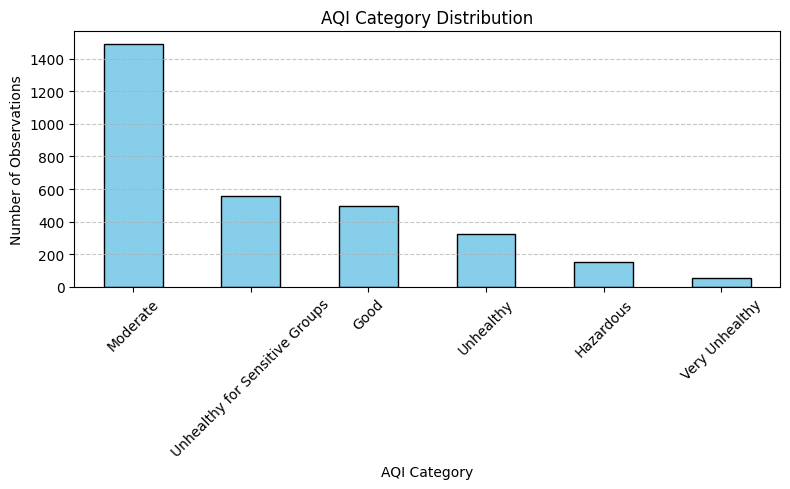

In [1071]:
category_counts = final_combined_df['AQI_Category'].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('AQI Category Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The "Moderate" AQI category has the highest number of observations, which is a common outcome in urban air quality datasets. This reflects typical, day-to-day air conditions where pollutant levels are elevated due to vehicle traffic, household activities and mild industrial emissions, but not high enough to trigger health warnings for the general population. In many environments, especially outside of extreme weather events or major pollution incidents, air quality tends to fluctuate within this moderate range. This suggests that while the air may not be perfectly clean, it is generally acceptable for most people, with only limited risk for sensitive individuals.

In [1072]:
final_combined_df.isnull().sum()

co                  0
no2                 0
so2                 0
o3                  0
pm10                0
pm25                0
datetime_local      0
AQI               152
AQI_Category        0
dtype: int64

In [1073]:
final_combined_df = final_combined_df.dropna(subset=['AQI'])

In [1074]:
final_combined_df.sample(10)

co    no2    so2      o3   pm10   pm25    datetime_local    AQI  \
100   500.0  44.18  25.18   42.94  28.95  10.52  2025-01-06 12:00   54.0   
2313  390.0  18.71  17.11  120.68  16.82  11.66  2025-05-06 16:00  216.0   
2789  300.0   4.08   8.25   62.75  12.54   4.05  2025-05-31 08:00   76.0   
0     400.0  23.33  20.16   56.93  24.27  18.38  2020-04-20 17:00   68.0   
83    290.0   3.08  19.92   83.05  23.42  14.79  2020-04-26 06:00  143.0   
51    470.0  27.49  20.53   66.08  17.00  31.55  2020-04-23 07:00   93.0   
98    310.0  16.30  19.02   49.25  17.26  12.20  2020-04-26 23:00   57.0   
1478  590.0  32.19   8.52   42.14  39.03   8.59  2025-03-22 00:00   48.0   
2367  330.0  14.36   7.41   69.07  13.27   5.61  2025-05-09 13:00   97.0   
2200  370.0   4.15  10.54   79.63  10.27   4.96  2025-04-27 07:00  131.0   

                        AQI_Category  
100                         Moderate  
2313                  Very Unhealthy  
2789                        Moderate  
0                           Moderate  
83    Unhealthy for Sensitive Groups  
51                          Moderate  
98                          Moderate  
1478                            Good  
2367                        Moderate  
2200  Unhealthy for Sensitive Groups

## Data Analysis and Visualization 📊

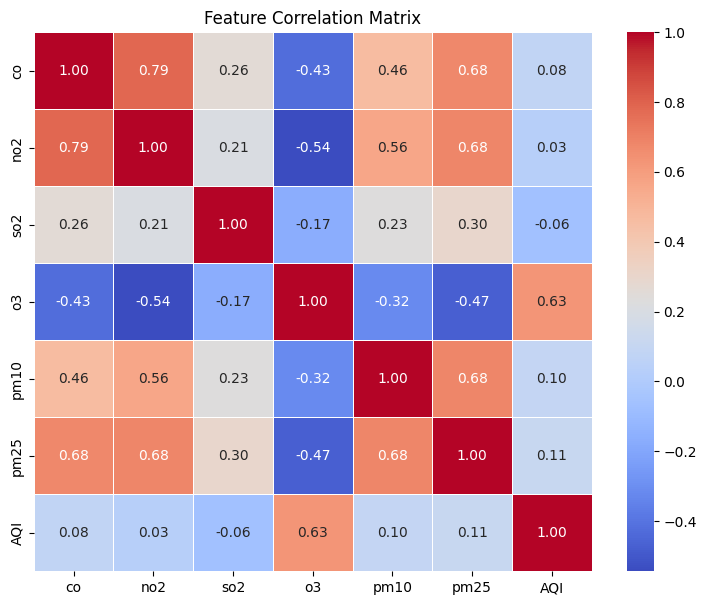

In [1075]:
numeric_df = final_combined_df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(9, 7))
seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Feature Correlation Matrix')
plt.show()

This is a correlation matrix heatmap showing the relationships between various air quality features: carbon monoxide (co), nitrogen dioxide (no2), sulfur dioxide (so2), ozone (o3), particulate matter ≤10μm (pm10), particulate matter ≤2.5μm (pm25) and the Air Quality Index (AQI). Each cell contains the Pearson correlation coefficient between two features, ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation). Red shades indicate strong positive correlations, blue shades indicate strong negative correlations and neutral colors show weak or no correlation.

**Key observations:**
- co and no2 have a strong positive correlation (0.79), meaning they tend to increase or decrease together.
- pm10 and pm25 are also strongly positively correlated (0.68), reflecting their similar sources and behavior.
- o3 is negatively correlated with no2 (-0.54) and pm25 (-0.47), indicating that as ozone increases, these pollutants tend to decrease.
- AQI has a moderate positive correlation with o3 (0.63), suggesting ozone levels significantly influence air quality in this dataset.
- Other correlations, such as AQI with co, no2, so2, pm10 and pm25, are weak (close to zero).

This matrix helps identify which pollutants are closely related, which can inform air quality analysis and modeling.

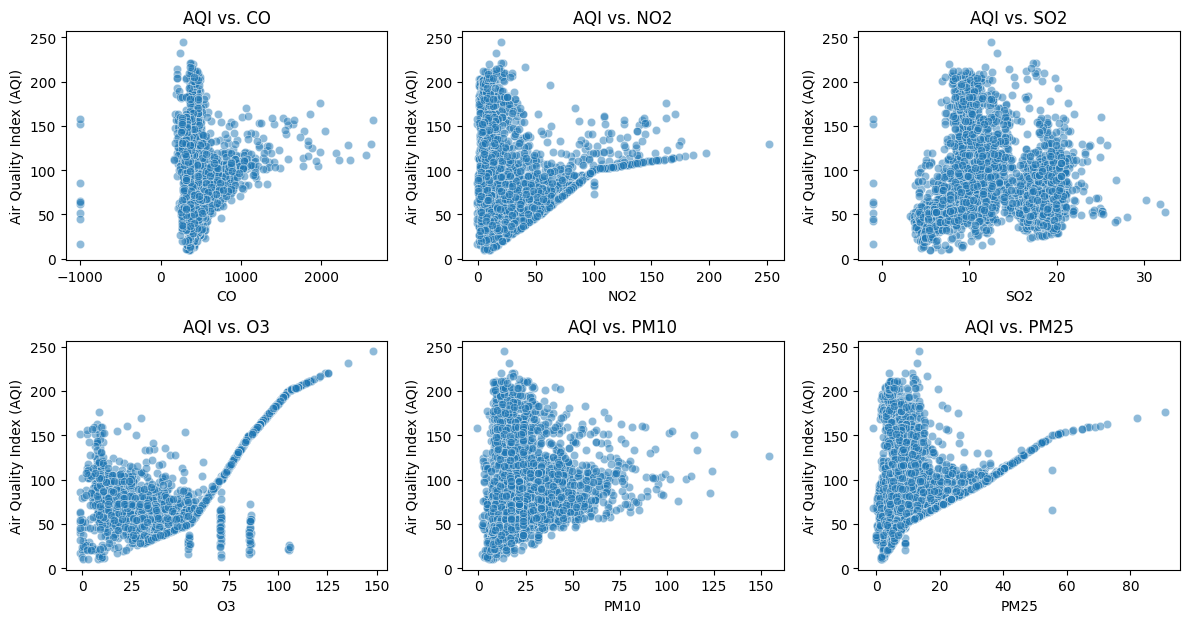

In [1076]:
air_quality_features = ["co", "no2", "so2", "o3", "pm10", "pm25"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
axes = axes.flatten()

for i, feature in enumerate(air_quality_features):
    seaborn.scatterplot(
        x=final_combined_df[feature],
        y=final_combined_df["AQI"], 
        alpha=0.5,
        ax=axes[i] 
    )
    axes[i].set_xlabel(feature.upper())
    axes[i].set_ylabel("Air Quality Index (AQI)")
    axes[i].set_title(f"AQI vs. {feature.upper()}")

for j in range(len(air_quality_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

These scatter plots show the relationship between the Air Quality Index (AQI) and six air pollutants: carbon monoxide (CO), nitrogen dioxide (NO2), sulfur dioxide (SO2), ozone (O3), particulate matter ≤10μm (PM10) and particulate matter ≤2.5μm (PM25). Each point represents a data sample, with the pollutant concentration on the x-axis and the AQI value on the y-axis.

**Key observations:**
- CO (Carbon Monoxide): The points are widely scattered and form a triangular pattern, suggesting there is no strong or consistent relationship between CO levels and AQI in this dataset.
- NO2 (Nitrogen Dioxide): Similar to CO, the data points are spread out in a triangular shape, indicating only a weak or inconsistent relationship between NO2 and AQI.
- SO2 (Sulfur Dioxide): The points are clustered without a clear trend, showing little to no direct relationship between SO2 and AQI.
- O3 (Ozone): There is a noticeable upward trend, especially at higher ozone levels. As O3 increases, AQI also tends to increase, indicating a stronger positive relationship compared to the other pollutants.
- PM10 (Particulate Matter ≤10μm): The scatter is wide and triangular, showing a weak relationship between PM10 and AQI.
- PM25 (Particulate Matter ≤2.5μm): The pattern is similar to PM10, with a wide spread of AQI values for most PM25 concentrations, indicating a weak relationship.

Overall, these plots indicate that among the pollutants shown, ozone (O3) has the strongest visible association with AQI, while the others show weaker or less clear relationships. This suggests that, in this dataset, AQI is most sensitive to changes in ozone levels.

## Target variable 🎯

In [1077]:
features = ['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']
target = 'AQI'

X = final_combined_df[features]
y = final_combined_df[target]

## Splitting into train/test 🪓
We will use 80% of the data for training and the rest - 20% for testing. This split allows the model to learn from the majority of the data while keeping a separate portion to evaluate its performance on unseen examples, helping us measure how well it generalizes.

In [1078]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 2929 observations, of which 2343 are now in the train set and 586 in the test set.


## Modelling 🧬

In [1079]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Bagging': BaggingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'LGBM': LGBMRegressor(force_col_wise=True, verbose=-1),
    'CatBoost': CatBoostRegressor(verbose=0)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append((name, mae, mse, r2))

results_df = pandas.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'R²'])
results_df = results_df.sort_values('MAE')

results_df

Model        MAE          MSE        R²
1       Random Forest   0.939283    10.873438  0.994438
5             Bagging   0.981229     9.475256  0.995153
4         Extra Trees   1.966638    32.308515  0.983473
2             XGBoost   2.861790    91.604010  0.953142
10               LGBM   2.930470    68.514247  0.964953
11           CatBoost   3.133157    64.143346  0.967189
3   Gradient Boosting   3.286362    52.600308  0.973093
7                 KNN  10.268259   306.407782  0.843264
0   Linear Regression  20.455841   647.977642  0.668541
8               Ridge  20.455850   647.977804  0.668541
9               Lasso  20.478284   648.544294  0.668251
6                 SVR  29.018499  1694.639428  0.133144

**Best Models**: 
- **Random Forest**: Top performer with the lowest MAE and MSE and highest R².
- **Bagging** and **Extra Trees**: Close contenders with excellent accuracy.

**Intermediate Models**: 
- **XGBoost**, **LGBM** and **CatBoost**: Reasonable performance, but slightly higher errors compared to top models.

**Underperformers**: 
- **KNN**: Moderate performance with significant errors.
- **Linear Models (Linear Regression, Ridge, Lasso)**: Poor fit for this dataset, unable to capture non-linear patterns.
- **SVR**: Worst performer with very high errors and low R².

Random Forest will be used for optimal accuracy, balancing computational efficiency and performance.


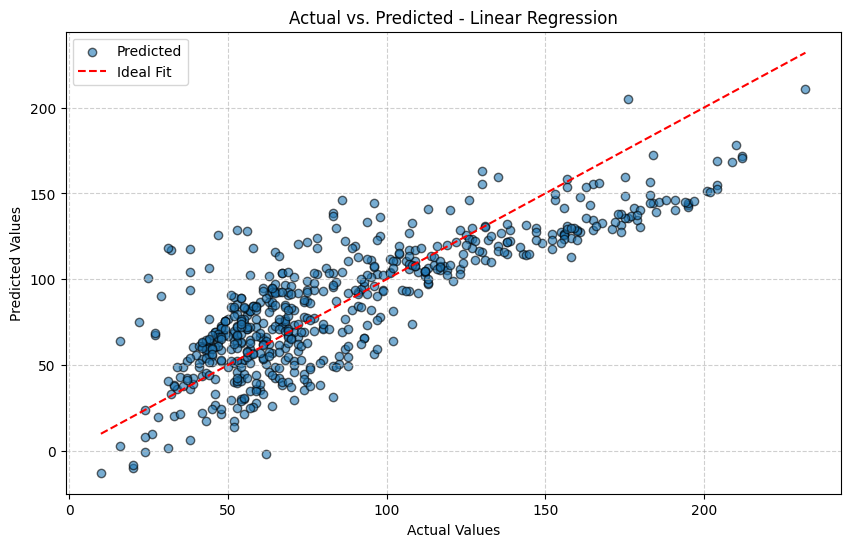

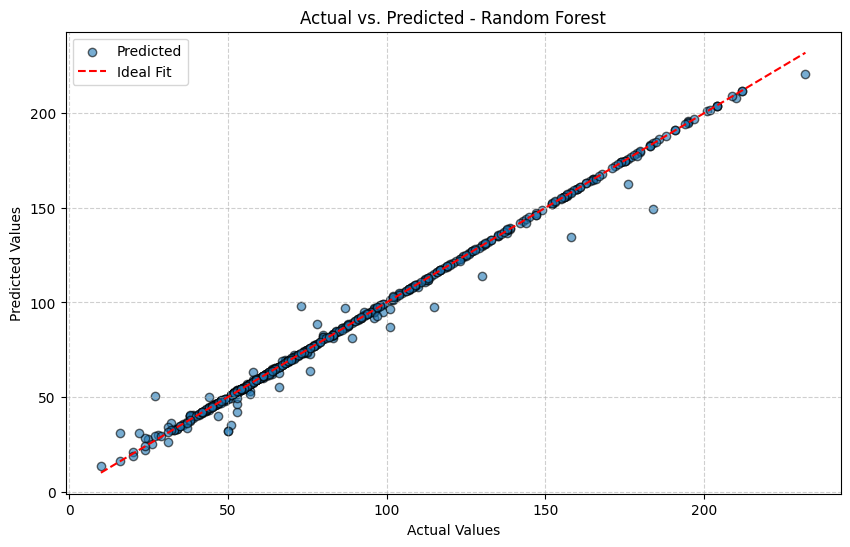

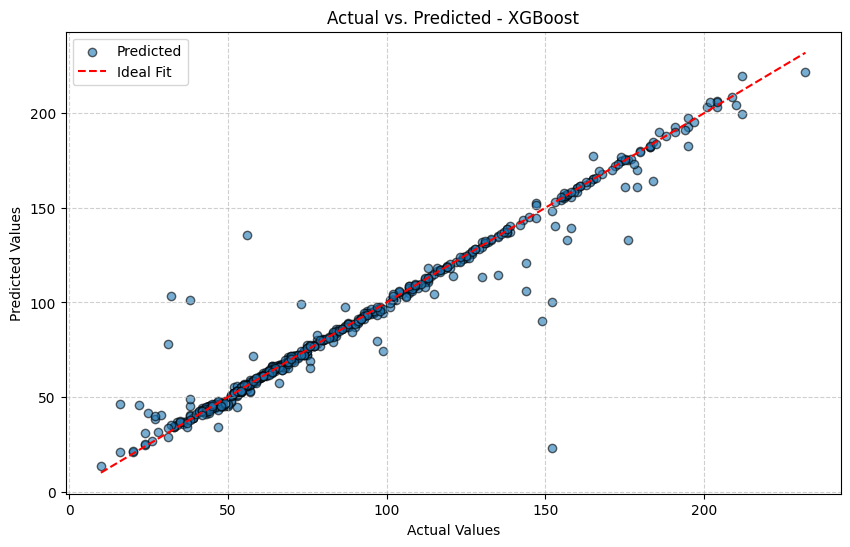

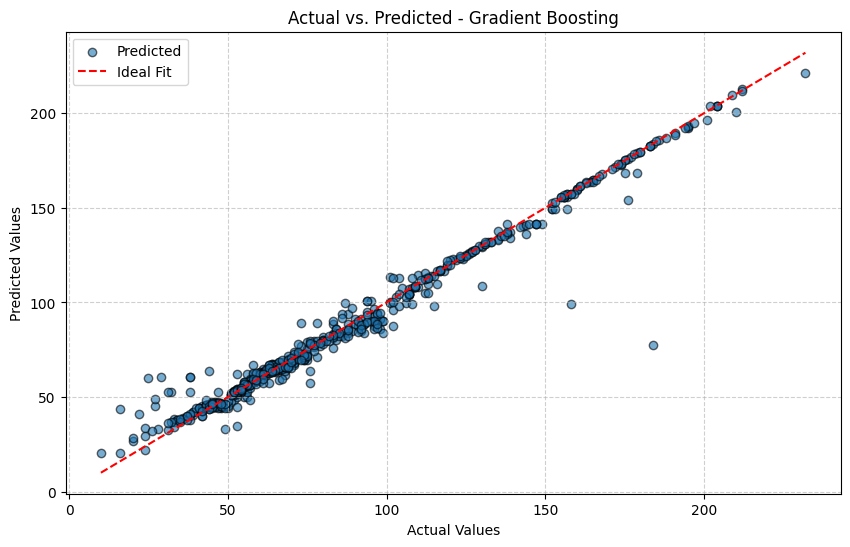

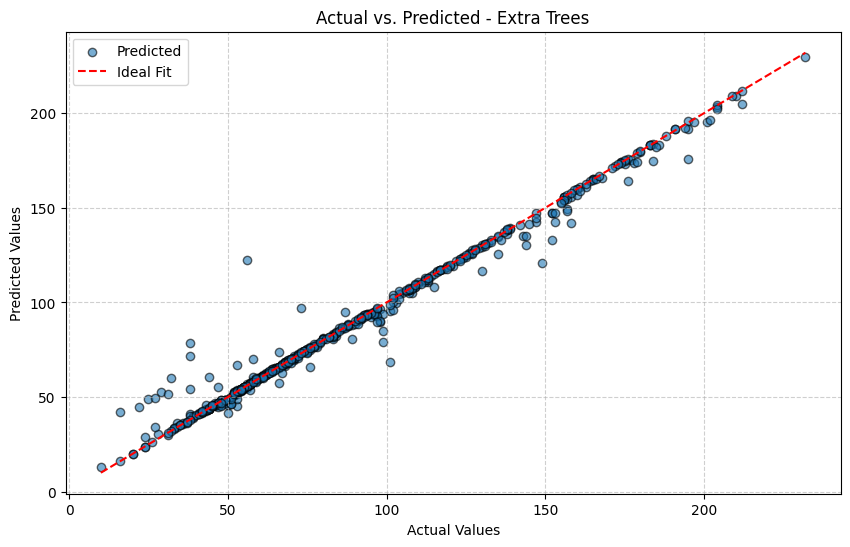

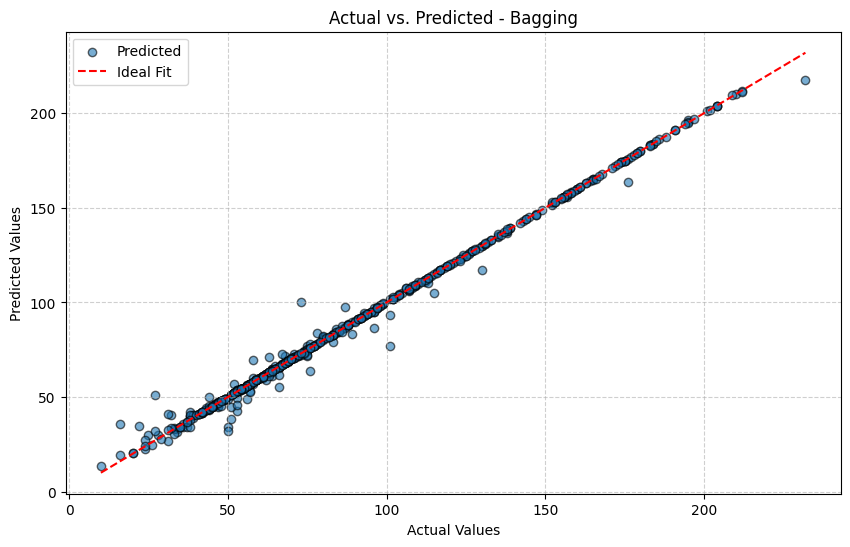

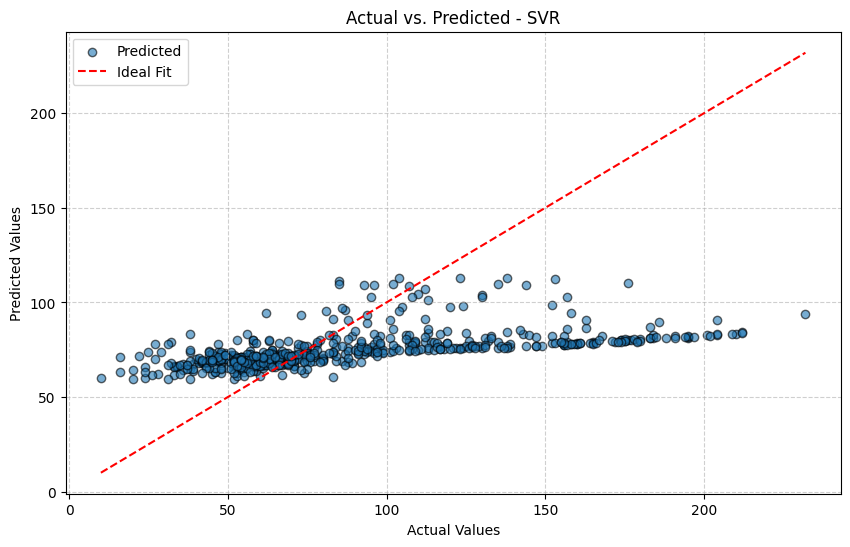

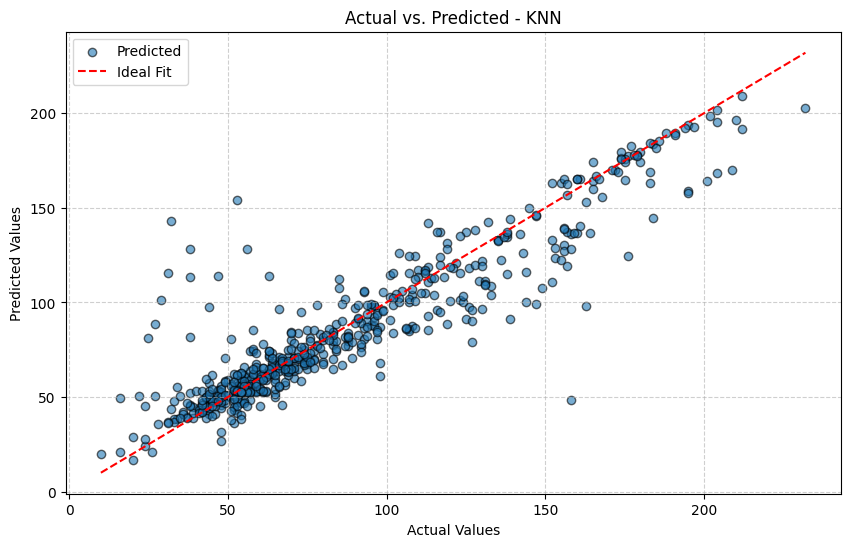

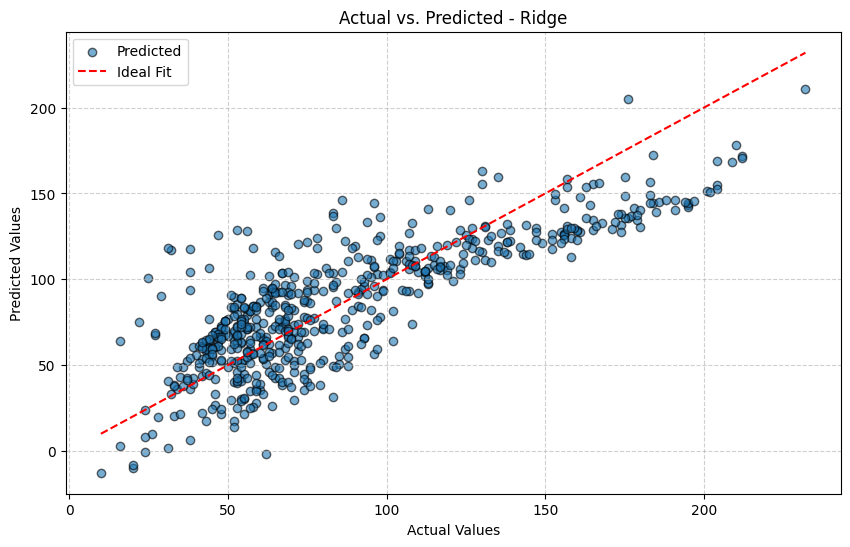

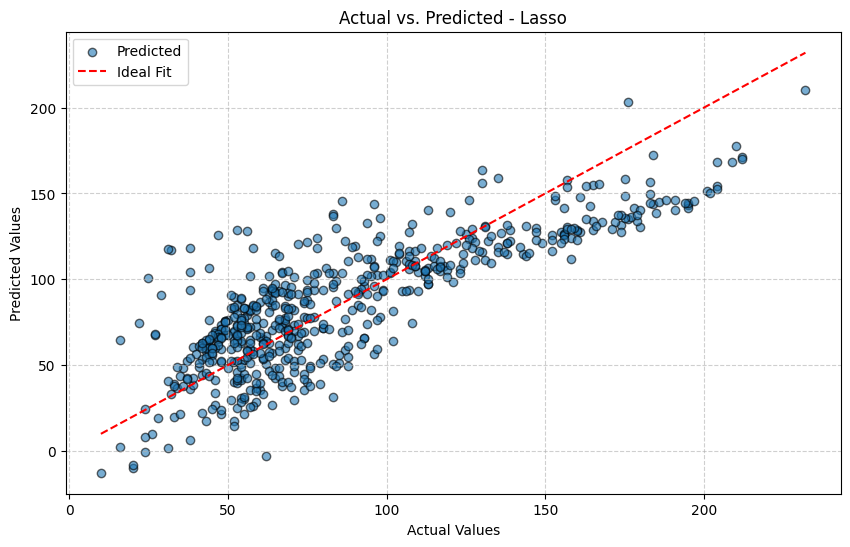

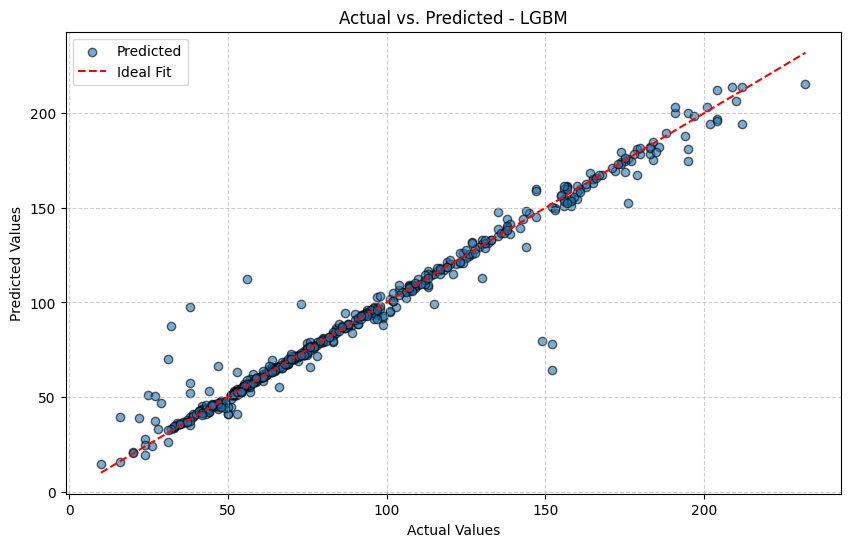

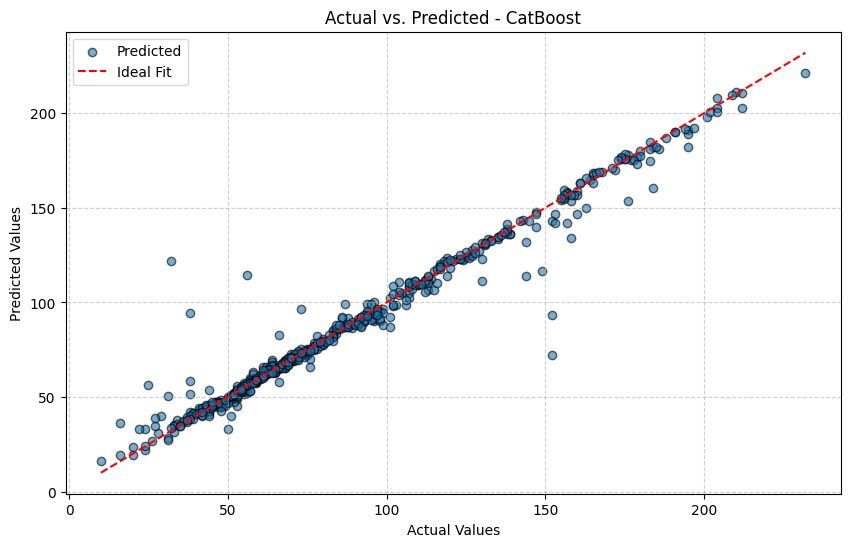

In [1080]:
for name, model in models.items():
    preds = model.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, alpha=0.6, edgecolor='k', label='Predicted')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit')
    plt.title(f"Actual vs. Predicted - {name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

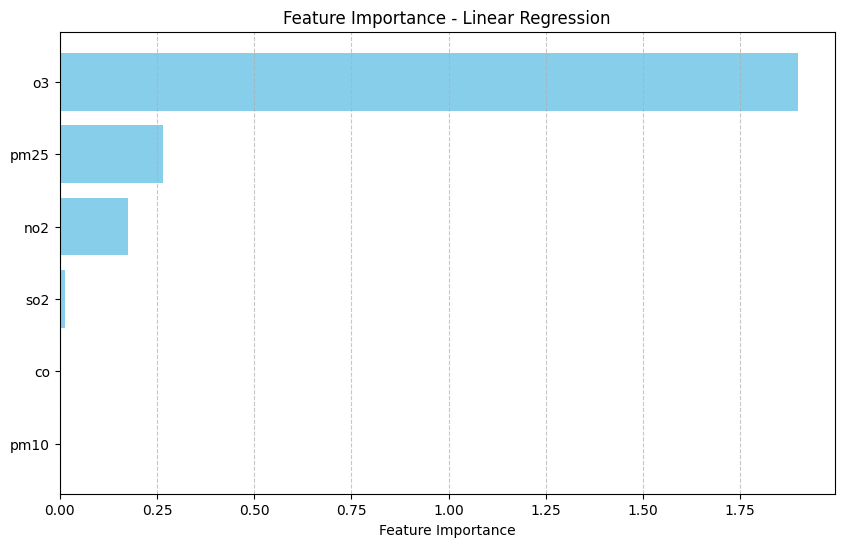

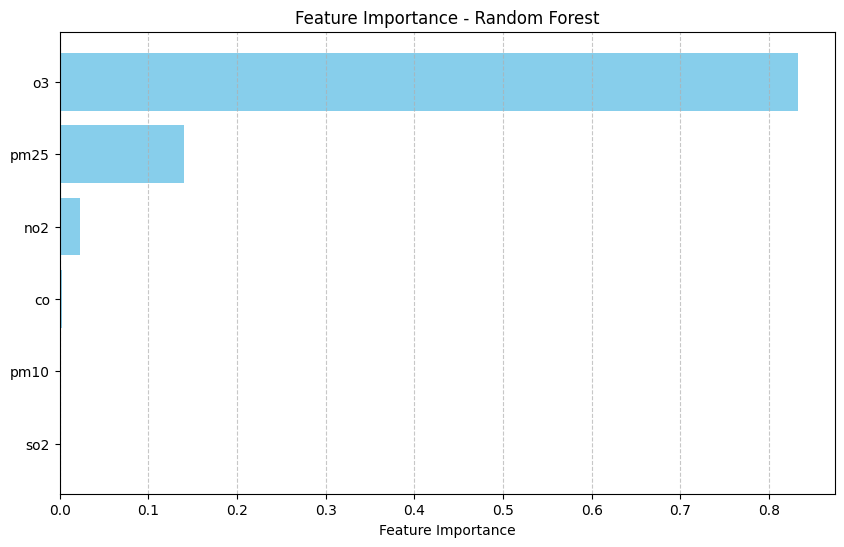

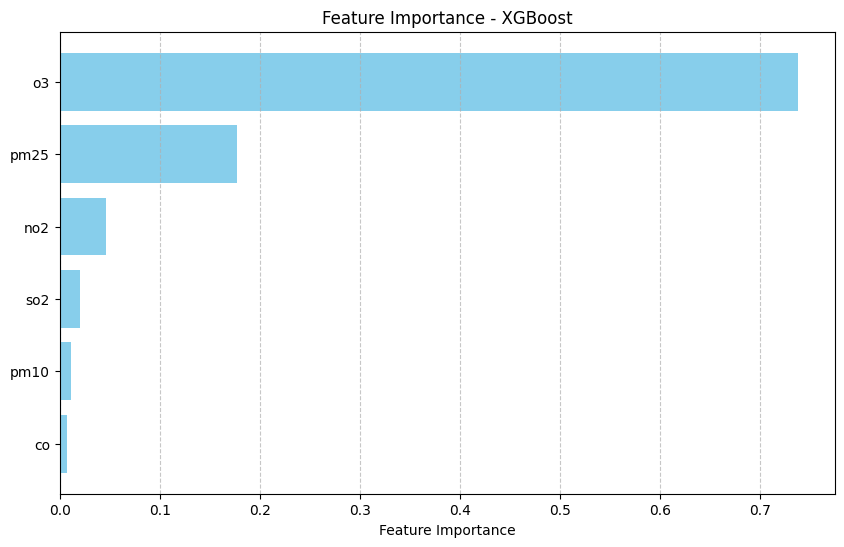

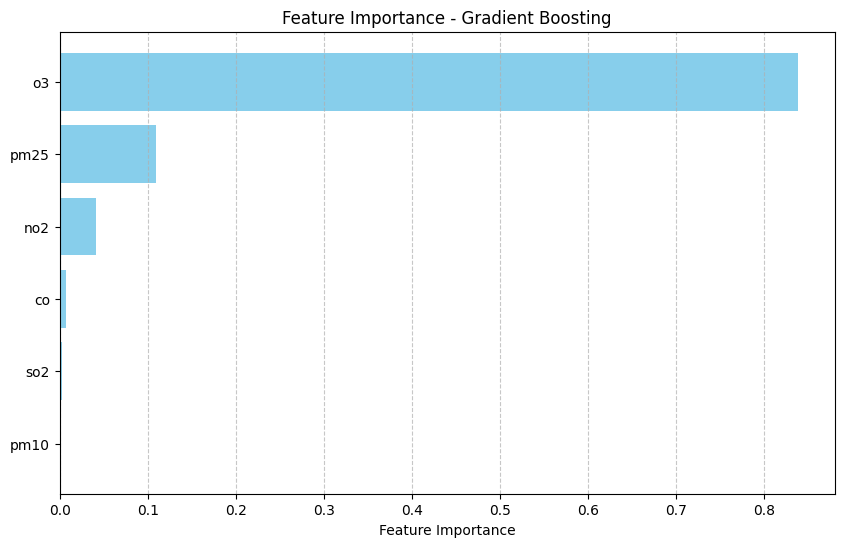

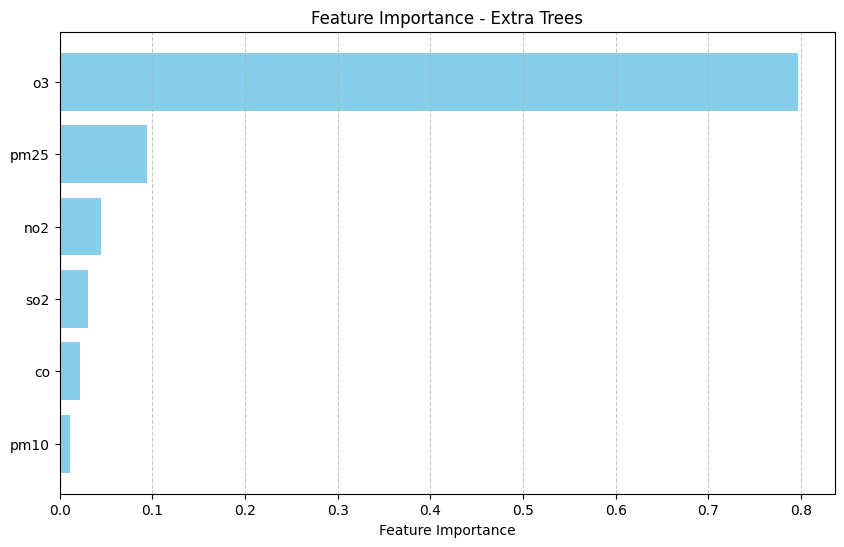

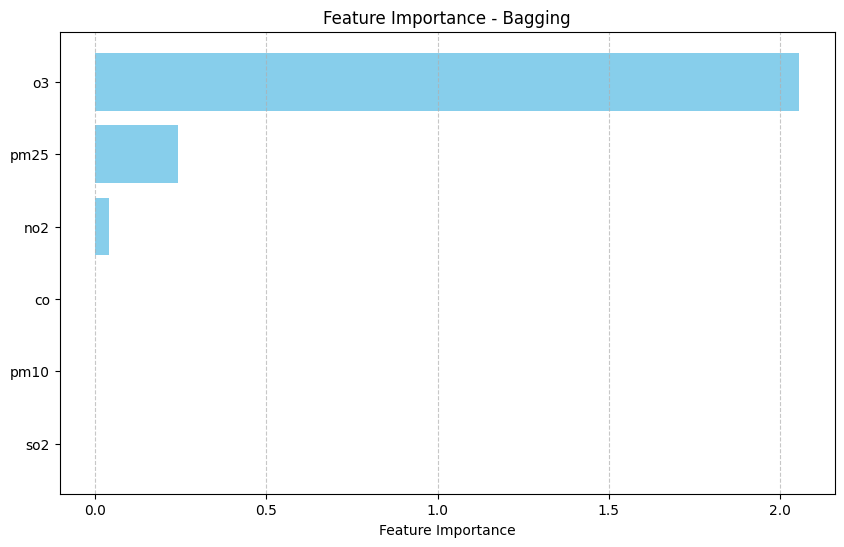

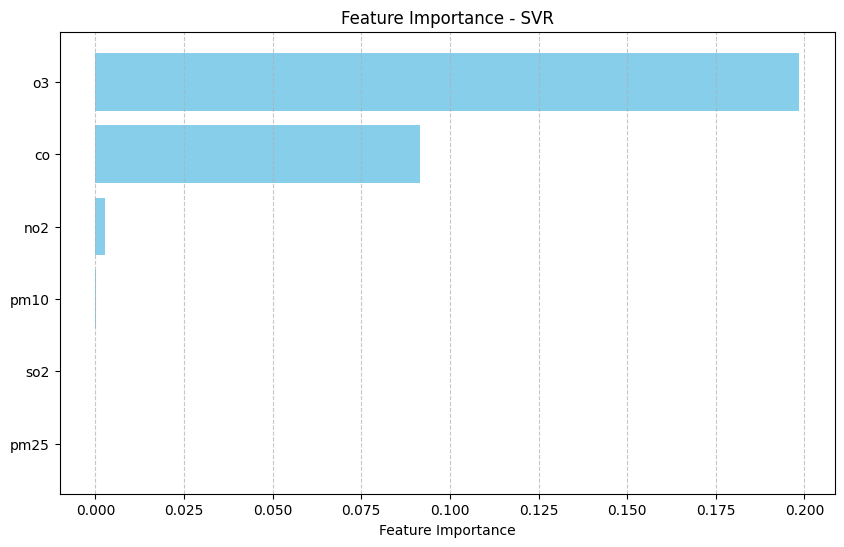

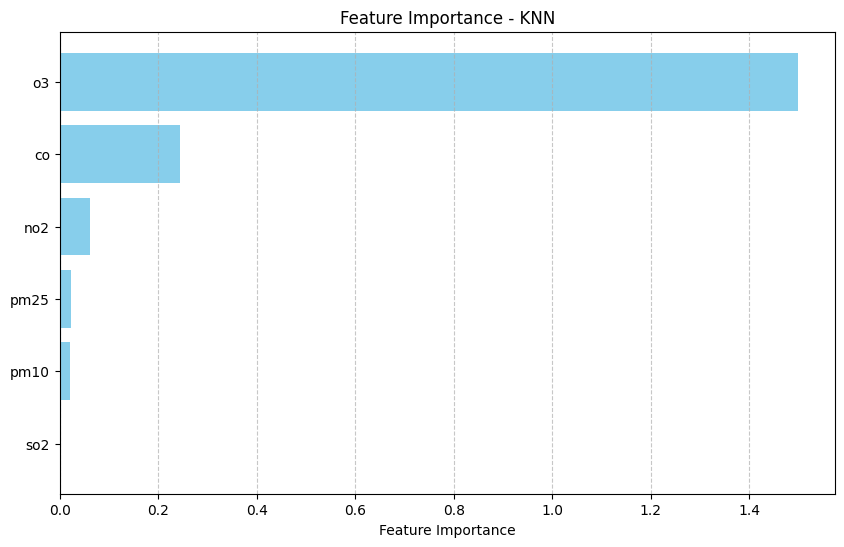

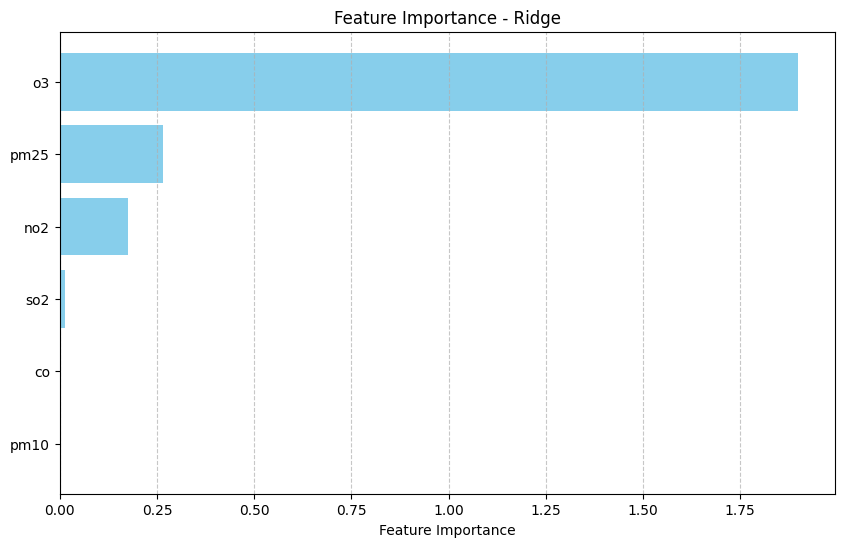

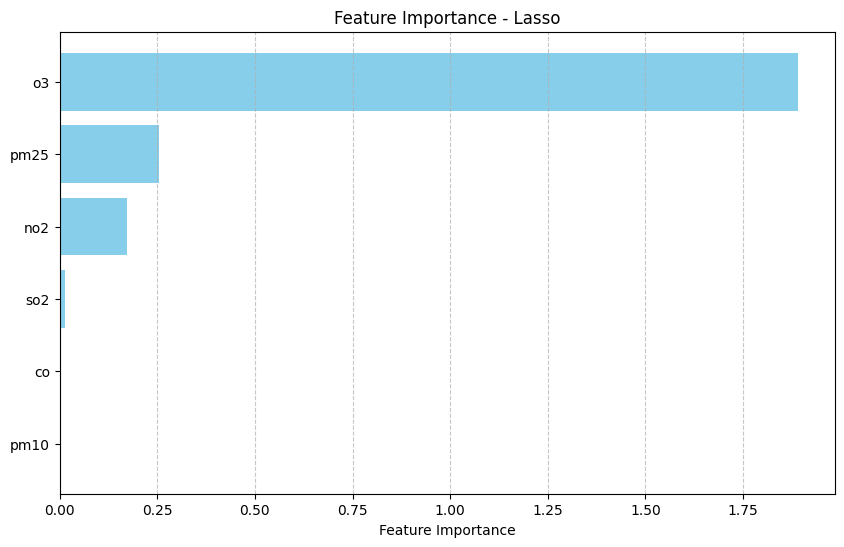

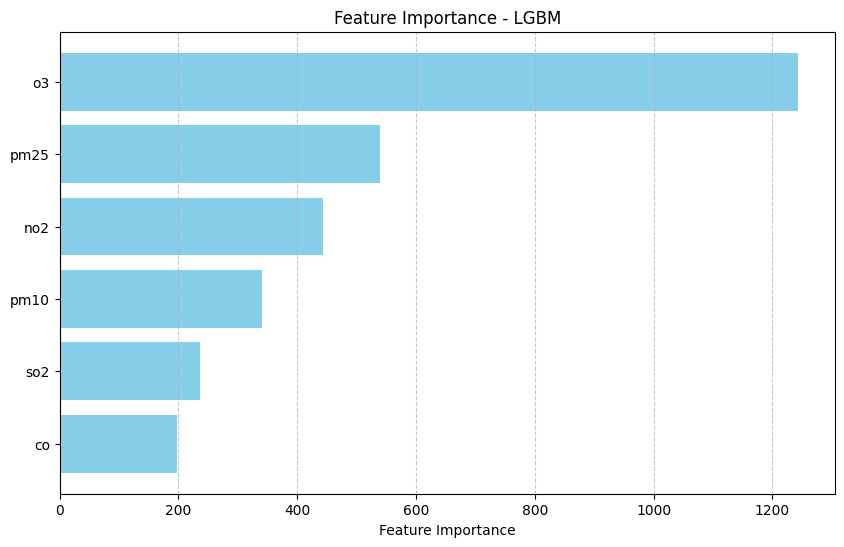

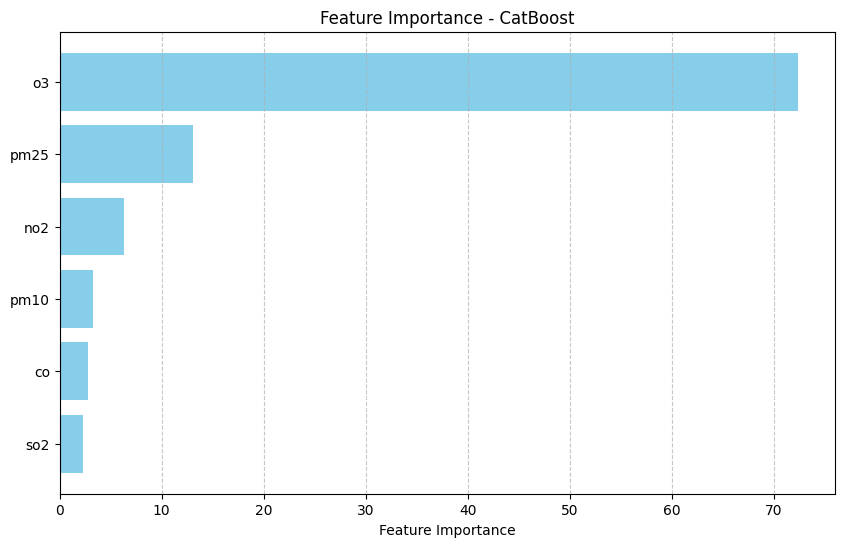

In [1081]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

for name, model in models.items():
    if hasattr(model, "feature_importances_"):  # for tree-based models
        importances = model.feature_importances_
    else:  # the rest - use permutation importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importances = perm_importance.importances_mean

    sorted_idx = numpy.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importances = importances[sorted_idx]
    
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances, color="skyblue")
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance - {name}")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

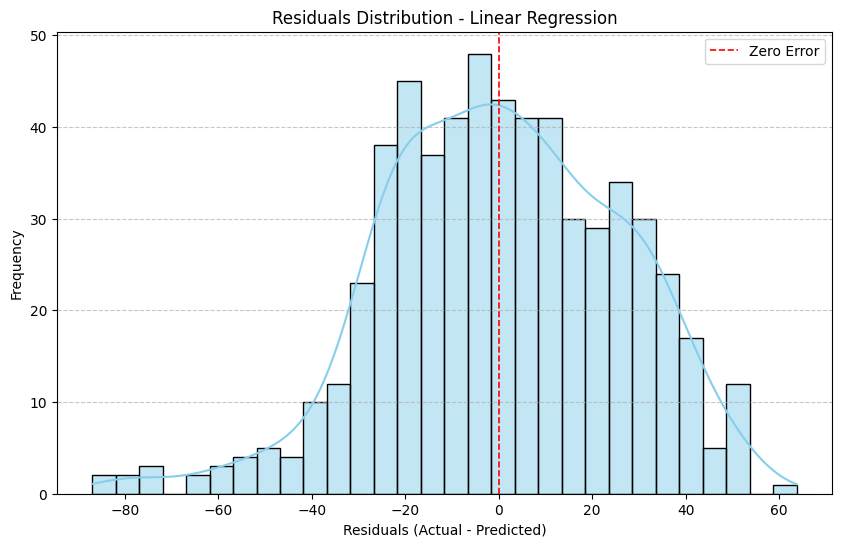

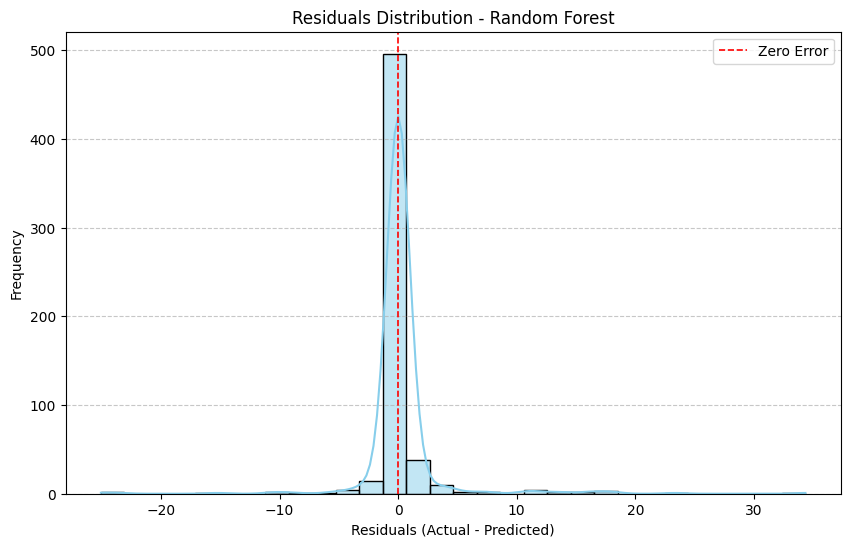

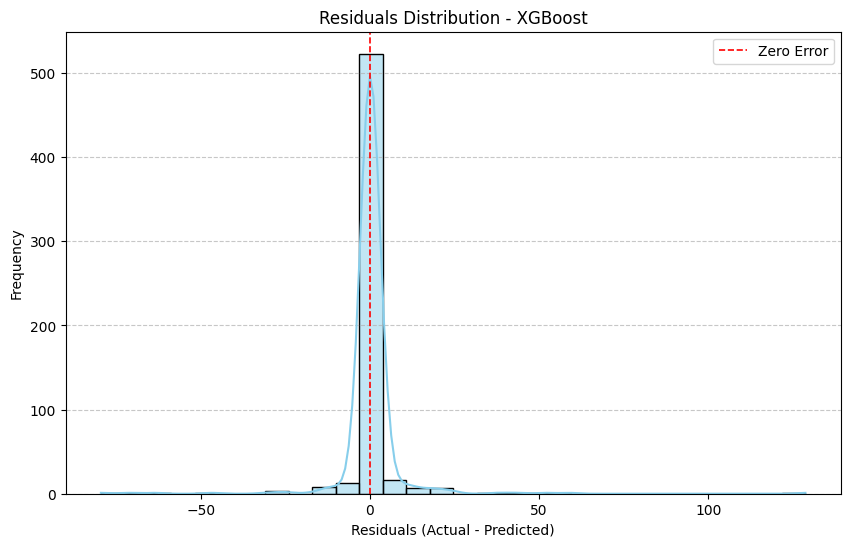

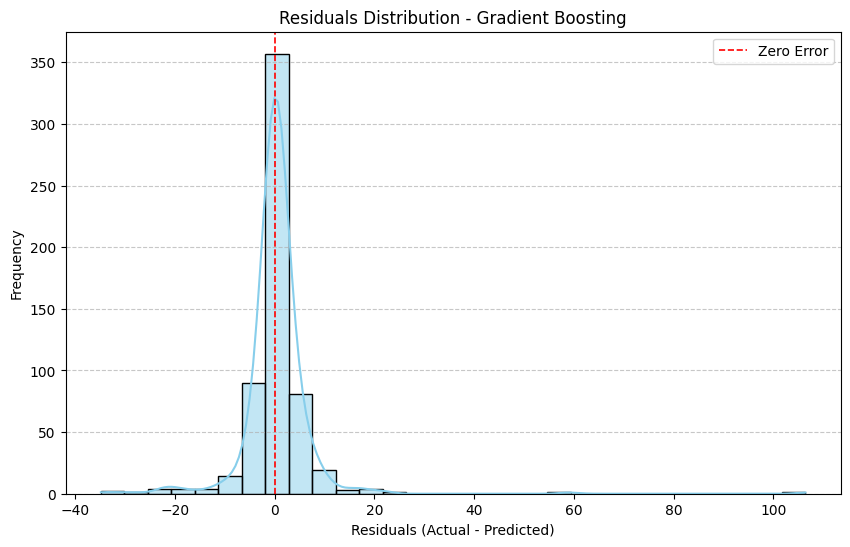

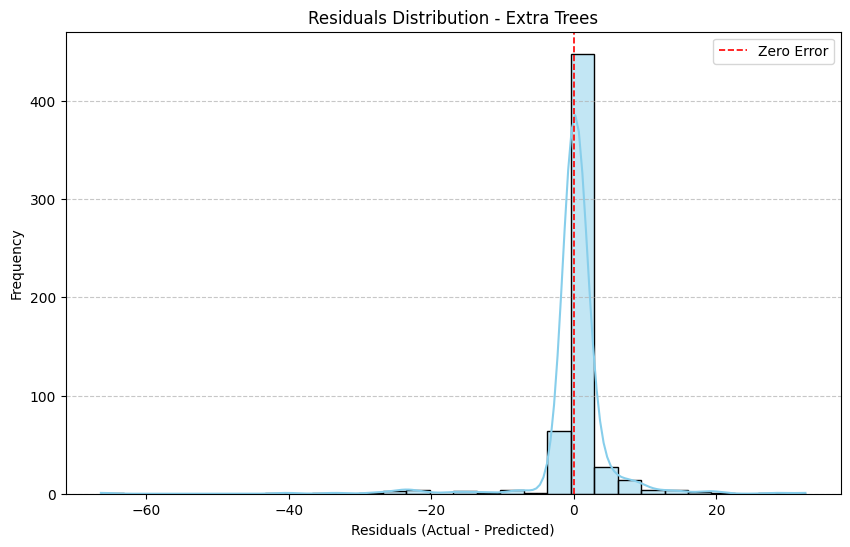

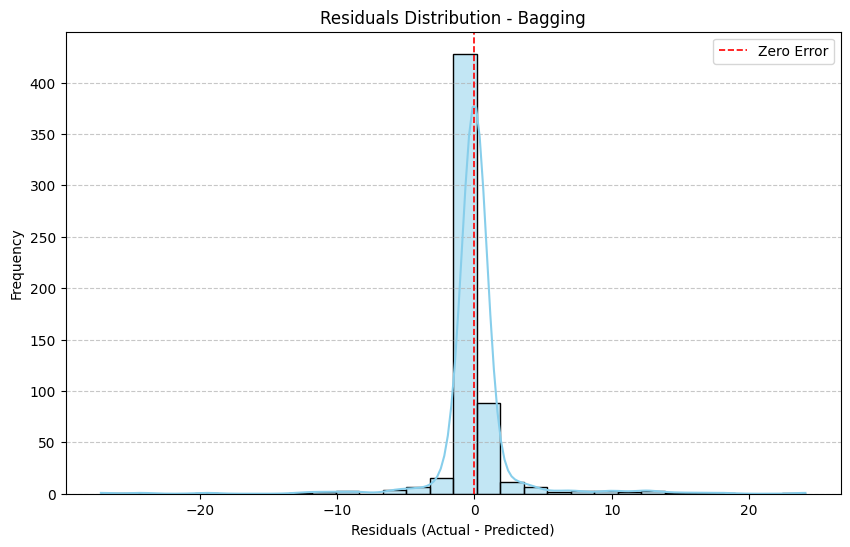

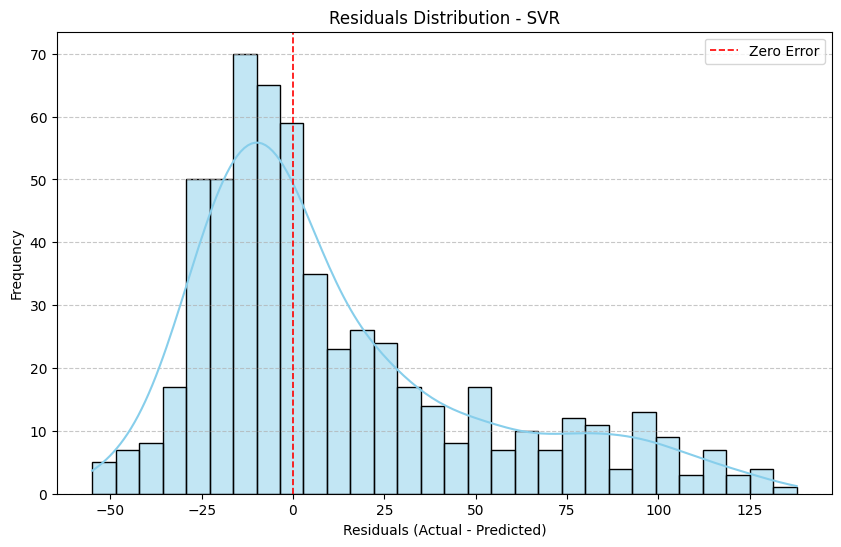

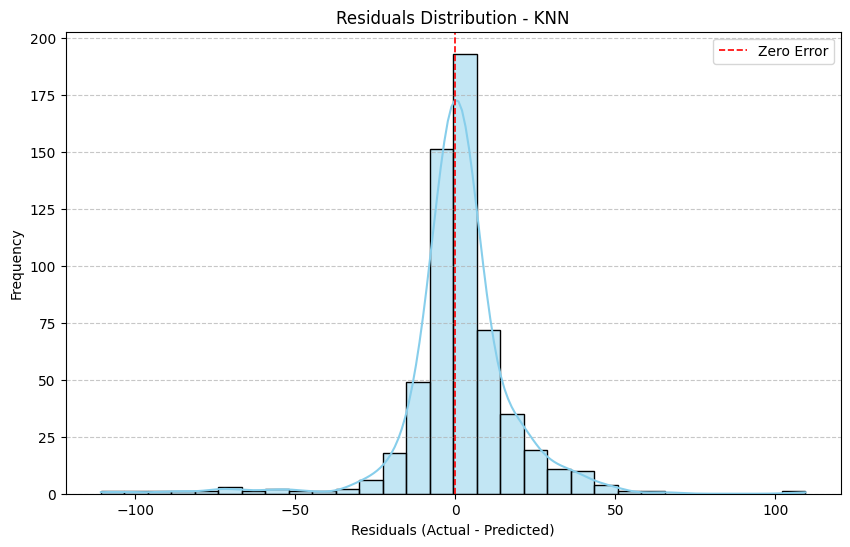

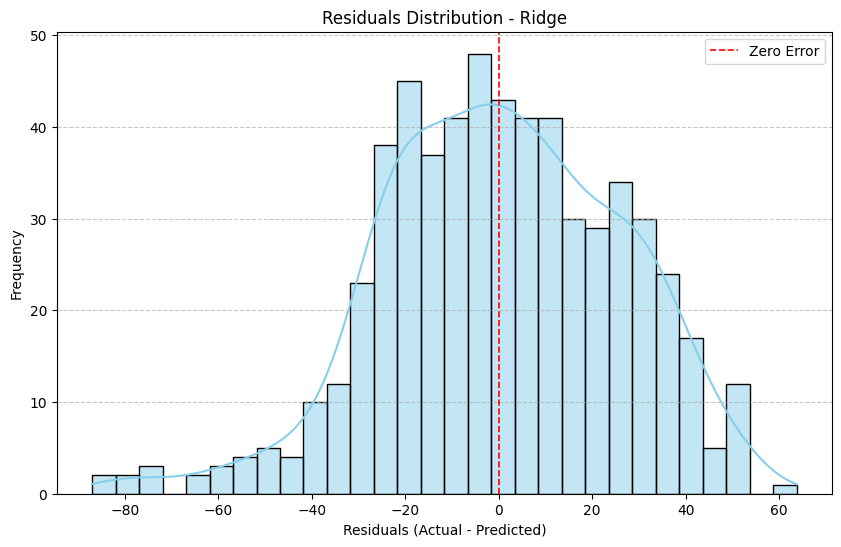

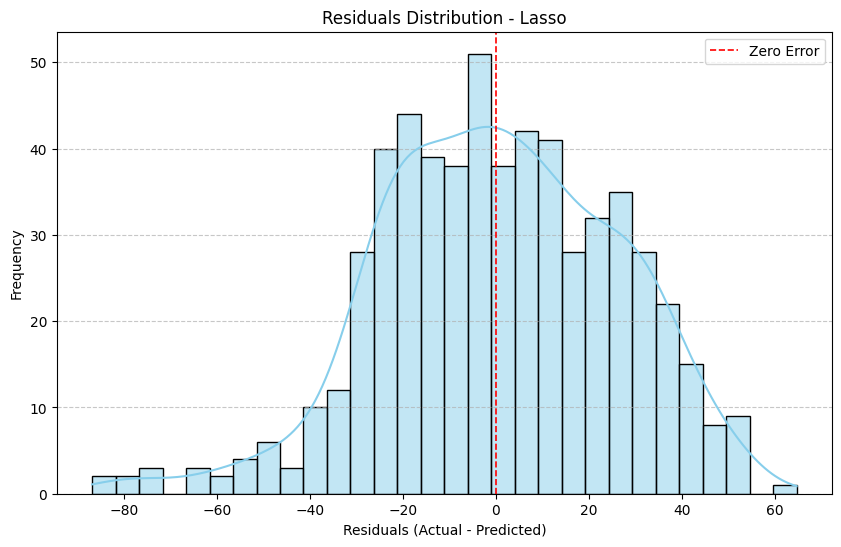

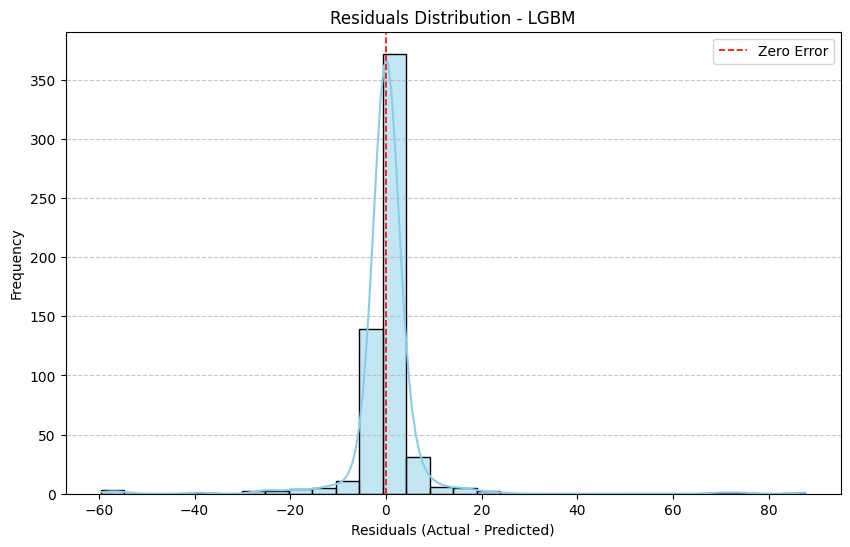

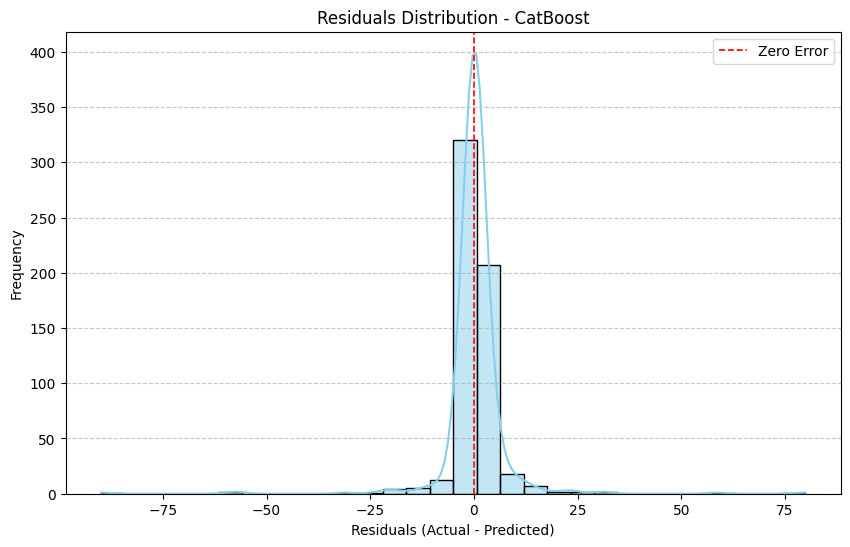

In [1082]:
for name, model in models.items():
    preds = model.predict(X_test)
    residuals = y_test - preds
    
    plt.figure(figsize=(10, 6))
    seaborn.histplot(residuals, kde=True, color="skyblue", bins=30, edgecolor="black")
    plt.title(f"Residuals Distribution - {name}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', linewidth=1.2, label="Zero Error")
    plt.legend()
    plt.show()